In [1]:
%xmode verbose

Exception reporting mode: Verbose


In [2]:
!pip install statsforecast -q
!pip install neuralforecast -q
!pip install datasetsforecast -q
!pip install darts -q
!pip install sktime==0.17.0 -q
!pip install pycaret -q
# !pip install prophet -q
# !pip install MissForest -q
# !pip install pycaret -q

# !pip install pytest -q

# Faktor yang mempengaruhi Data Emas

In Indonesia, the factors that can impact the gold price are:

1. Supply and demand: The relationship between the supply of and demand for gold is a key factor affecting its price.
2. Economic conditions: Economic conditions in Indonesia, such as inflation, recession, and interest rates, can affect the demand for gold and thus its price.
3. Political stability: Political stability and uncertainty in Indonesia can impact the demand for gold as a safe haven asset and thereby affect its price.
4. Currency fluctuations: Changes in the value of the Indonesian Rupiah against other major currencies can impact the price of gold.
5. Mining and production costs: The cost of mining and producing gold in Indonesia can impact its price.
6. Jewelry demand: The demand for gold in the jewelry industry can impact its price.
7. Technology demand: The demand for gold in technology applications can impact its price.
8. Central bank buying and selling: Central bank activities, such as buying and selling gold, can impact its price.

Reference:

KPMG. (2018). The gold market: A review of the supply chain, demand, and pricing. In KPMG International (Ed.), Global Precious Metals Handbook 2018 (pp. 12-24). KPMG International.
Torgler, B. (2017). Gold demand, supply, and price dynamics: A macroeconomic analysis. In Gold Demand, Supply and Price Dynamics (pp. 1-23). Emerald Publishing Limited.
Buiter, W. H. (2012). The economics of gold. Handbook of Commodity Markets and Investment (pp. 557-592). Springer.

# Persiapan Dataset

In [3]:
from prophet import Prophet
from statsmodels.tsa.stattools import grangercausalitytests
from statsforecast.adapters.prophet import AutoARIMAProphet

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
import seaborn as sns

from sktime.transformations.panel.tsfresh import (
    TSFreshRelevantFeatureExtractor,
    TSFreshFeatureExtractor
)
from sktime.transformations.panel.catch22 import Catch22

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
%matplotlib inline

In [5]:
logging.getLogger("prophet").setLevel(logging.CRITICAL)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('pystan').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('statsmodels').setLevel(logging.CRITICAL)

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.base.model")
warnings.filterwarnings("ignore")

## Fungsi Tambahan

In [6]:
from datasetsforecast.losses import mse, mae, rmse

def eva_cro_val_sf(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [7]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_matrix(data, variables, maxlag, test='ssr_chi2test'):
    """
    This function returns two dataframes with results of granger causality tests for all pairs of variables.
    
    Parameters:
        data (DataFrame): The input data, containing all variables in the form of a time series.
        variables (list): List of all the variables to be tested.
        maxlag (int): Maximum number of lags to test.
        test (str): Test statistic to use (default is 'ssr_chi2test').
    
    Returns:
        tuple: Two dataframes, the first one contains the minimum lags where causality is found, and the second one contains the p-values at those lags.
    """
    num_vars = len(variables) # Number of variables
    df1 = pd.DataFrame(np.zeros((num_vars, num_vars)), columns=[var + "_y" for var in variables], index=[var + "_x" for var in variables])
    df2 = pd.DataFrame(np.zeros((num_vars, num_vars)), columns=[var + "_y" for var in variables], index=[var + "_x" for var in variables])
    
    # Loop through all variable combinations
    for i in range(num_vars):
        for j in range(i+1, num_vars):
            result = None
            try:
                result = grangercausalitytests(data[[variables[i], variables[j]]], maxlag=maxlag, verbose=False)
                p_values = [round(result[lag][0][test][1], 10) for lag in range(1, maxlag+1)]
                min_lag = np.argmin(p_values)
                if min_lag == maxlag - 1 and p_values[min_lag] >= 0.05:
                    df1.loc[variables[i] + '_x', variables[j] + '_y'] = None
                    df2.loc[variables[i] + '_x', variables[j] + '_y'] = None
                else:
                    df1.loc[variables[i] + '_x', variables[j] + '_y'] = int(min_lag+1)
                    df2.loc[variables[i] + '_x', variables[j] + '_y'] = p_values[min_lag]
            except:
                df1.loc[variables[i] + '_x', variables[j] + '_y'] = None
                df2.loc[variables[i] + '_x', variables[j] + '_y'] = None
    return df1.T, df2.T

In [8]:
import statsmodels.api as sm

def make_stationary(data, max_diff = 10):
    """
    This function will return the stationary time series after difference has been applied and the number of differences applied.
    The input data should be a one-dimensional numpy array or pandas series.
    
    Parameters:
    data (numpy array or pandas series): The time series data that needs to be made stationary.
    max_diff (int, optional): The maximum number of differences to be applied. Defaults to 10.
    
    Returns:
    tuple: A tuple contains the stationary time series and the number of differences applied.
    """
    diff = 0
    result = sm.tsa.stattools.adfuller(data)
    while result[1] >= 0.05 and diff < max_diff:
        data = np.diff(data)
        result = sm.tsa.stattools.adfuller(data)
        diff += 1
    return data, diff


In [9]:
import pandas as pd

def date_to_ym(date_series):
    """
    Convert a pandas series of datetime dates into a series of strings in the format "YYYY-MM".
    
    Parameters:
        date_series (pd.Series): A pandas series of datetime dates.
    
    Returns:
        pd.Series: A pandas series of strings in the format "YYYY-MM".
    """
    datetime_series = pd.to_datetime(date_series)
    ym_series = datetime_series.dt.strftime("%Y-%m")
    return ym_series

In [10]:
from datetime import datetime

def indonesian_month_to_date(month_string_year_int):
    month_dict = {
        'Januari': '01',
        'Februari': '02',
        'Maret': '03',
        'April': '04',
        'Mei': '05',
        'Juni': '06',
        'Juli': '07',
        'Agustus': '08',
        'September': '09',
        'Oktober': '10',
        'November': '11',
        'Desember': '12'
    }
    split_string = month_string_year_int.split(" ")
    month = month_dict[split_string[0]]
    year = split_string[1]
    date_str = f"{year}-{month}"
    return date_str

In [11]:
def string_to_date_indo(date_string):
    """
    This function takes a date string in the format "dd month_name yyyy"
    (with support for Indonesian month names) and returns a datetime.date object.
    """
    
    # Dictionary to map Indonesian month names to English month names
    indonesian_months = {
        "Januari": "January",
        "Februari": "February",
        "Maret": "March",
        "April": "April",
        "Mei": "May",
        "Juni": "June",
        "Juli": "July",
        "Agustus": "August",
        "September": "September",
        "Oktober": "October",
        "November": "November",
        "Desember": "December"
    }
    
    # Replace the Indonesian month name in the input date_string with the corresponding English month name
    date_string = date_string.replace(date_string.split(" ")[1], indonesian_months[date_string.split(" ")[1]])
    
    # Parse the input date_string into a datetime.date object
    date_object = datetime.strptime(date_string, "%d %B %Y").date()
    
    # Return the datetime.date object
    return date_object

In [12]:
var_inter_model = {'tanggal':'ds',
                    'harga_emas':'y',
                    'kurs_jual':'kurs_jual',
                    'kurs_beli':'kurs_beli',
                    'data_inflasi':'data_inflasi',
                    'suku_bunga_bi':'suku_bunga_bi'}

var_model_inter = {'ds':'tanggal',
                    'y':'harga_emas',
                    'kurs_jual':'kurs_jual',
                    'kurs_beli':'kurs_beli',
                    'data_inflasi':'data_inflasi',
                    'suku_bunga_bi':'suku_bunga_bi'}

## Data Emas 

In [13]:
import numpy as np
import pandas as pd
from datetime import date, timedelta

## Cara Mendapatkan Data Harga Emas

1. Buka Link [ini](https://www.logammulia.com/id/harga-emas-hari-ini)
2. Buka Browser console
3. Ikutin langkah langkah Berikut ini

   1. Daptakan datanya

      ```javascript
      var obj = Highcharts.charts[0].options.series[0].data;
      ```

   2. Jadikan data tersebut jadi file berbentuk JSON

      ```javascript
      var data = "text/json;charset=utf-8," + encodeURIComponent(JSON.stringify(obj));
      ```

   3. Buatkan Tombol untuk mendownload file tersebut

   ```javascript
   $('<a href="data:' + data + '" download="data.json">download JSON</a>').appendTo("#container");
   ```


In [14]:
from datetime import datetime as dtime


direc = "/kaggle/input/data-emas-skripsi/Data_emas/"

tabel_emas         = pd.read_json(direc + 'data_emas.json')
tabel_emas.columns = ['tanggal','harga_emas']
# tabel_emas.tanggal
tabel_emas.tanggal = pd.to_datetime(tabel_emas.tanggal,unit='ms').dt.date

enddate = pd.to_datetime('2023-05-1').date()
tabel_emas = tabel_emas.loc[tabel_emas.tanggal < enddate]
tabel_emas = tabel_emas.iloc[tabel_emas.tanggal.drop_duplicates().index.tolist(),:]
tabel_emas = tabel_emas.reset_index(drop=True)
tabel_emas.tail(10)

tanggal  harga_emas
3817  2023-04-14     1084000
3818  2023-04-15     1067000
3819  2023-04-16     1067000
3820  2023-04-17     1066000
3821  2023-04-18     1054000
3822  2023-04-26     1062000
3823  2023-04-27     1062000
3824  2023-04-28     1062000
3825  2023-04-29     1056000
3826  2023-04-30     1056000

In [15]:
full_day = len(pd.date_range(start=tabel_emas.tanggal[0],end=tabel_emas.tanggal[((tabel_emas.shape[0])-1)]))
business_day = tabel_emas.shape[0]

print(f'Seluruh hari dari {tabel_emas.tanggal[0]} - {tabel_emas.tanggal[((tabel_emas.shape[0])-1)]} adalah {full_day}')
print(f'hari bisnis indonesia adalah {business_day}')
print(f'Hari yang kosong adalah {full_day - business_day}')

Seluruh hari dari 2010-01-04 - 2023-04-30 adalah 4865
hari bisnis indonesia adalah 3827
Hari yang kosong adalah 1038


In [16]:
tabel_emas

tanggal  harga_emas
0     2010-01-04      408000
1     2010-01-05      410000
2     2010-01-06      410000
3     2010-01-07      412000
4     2010-01-08      410000
...          ...         ...
3822  2023-04-26     1062000
3823  2023-04-27     1062000
3824  2023-04-28     1062000
3825  2023-04-29     1056000
3826  2023-04-30     1056000

[3827 rows x 2 columns]

## Data Kurs Dolar Ke Rupiah
* https://www.bi.go.id/id/statistik/informasi-kurs/transaksi-bi/default.aspx


In [17]:
# data 
# https://www.bi.go.id/id/statistik/informasi-kurs/transaksi-bi/default.aspx

data_kurs = pd.read_excel(direc + 'Kurs Transaksi USD.xlsx',skiprows=4)
data_kurs = data_kurs.drop(['NO','Nilai'],axis=1)
data_kurs.Tanggal = pd.to_datetime(data_kurs.Tanggal,format='%m/%d/%Y %I:%M:%S %p')
data_kurs.Tanggal = data_kurs.Tanggal.dt.date
data_kurs.head(20)

Kurs Jual  Kurs Beli     Tanggal
0    14824.75   14677.25  2023-04-28
1    14956.41   14807.59  2023-04-27
2    14929.27   14780.73  2023-04-26
3    14846.86   14699.14  2023-04-18
4    14739.33   14592.67  2023-04-17
5    14865.96   14718.04  2023-04-14
6    14940.33   14791.67  2023-04-13
7    14962.44   14813.56  2023-04-12
8    14979.52   14830.48  2023-04-11
9    15017.72   14868.28  2023-04-10
10   15007.67   14858.33  2023-04-06
11   14987.57   14838.43  2023-04-05
12   15064.95   14915.05  2023-04-04
13   15051.89   14902.11  2023-04-03
14   15137.31   14986.69  2023-03-31
15   15169.47   15018.53  2023-03-30
16   15163.44   15012.56  2023-03-29
17   15249.87   15098.13  2023-03-28
18   15264.94   15113.06  2023-03-27
19   15425.75   15272.25  2023-03-24

In [18]:
data_kurs.tail(20)

Kurs Jual  Kurs Beli     Tanggal
3259     9412.0     9318.0  2010-01-29
3260     9455.0     9361.0  2010-01-28
3261     9427.0     9333.0  2010-01-27
3262     9362.0     9268.0  2010-01-26
3263     9387.0     9293.0  2010-01-25
3264     9435.0     9341.0  2010-01-22
3265     9366.0     9272.0  2010-01-21
3266     9321.0     9229.0  2010-01-20
3267     9271.0     9179.0  2010-01-19
3268     9276.0     9184.0  2010-01-18
3269     9251.0     9159.0  2010-01-15
3270     9196.0     9104.0  2010-01-14
3271     9226.0     9134.0  2010-01-13
3272     9231.0     9139.0  2010-01-12
3273     9176.0     9084.0  2010-01-11
3274     9286.0     9194.0  2010-01-08
3275     9274.0     9182.0  2010-01-07
3276     9355.0     9261.0  2010-01-06
3277     9355.0     9261.0  2010-01-05
3278     9377.0     9283.0  2010-01-04

In [19]:
tabel_emas_kurs = pd.merge(tabel_emas, data_kurs,
                           how='left',
                           left_on='tanggal',
                           right_on='Tanggal')
tabel_emas_kurs = tabel_emas_kurs.drop(['Tanggal'],axis=1)
tabel_emas_kurs["month_year"] = date_to_ym(tabel_emas_kurs.tanggal)
tabel_emas_kurs

tanggal  harga_emas  Kurs Jual  Kurs Beli month_year
0     2010-01-04      408000    9377.00    9283.00    2010-01
1     2010-01-05      410000    9355.00    9261.00    2010-01
2     2010-01-06      410000    9355.00    9261.00    2010-01
3     2010-01-07      412000    9274.00    9182.00    2010-01
4     2010-01-08      410000    9286.00    9194.00    2010-01
...          ...         ...        ...        ...        ...
3822  2023-04-26     1062000   14929.27   14780.73    2023-04
3823  2023-04-27     1062000   14956.41   14807.59    2023-04
3824  2023-04-28     1062000   14824.75   14677.25    2023-04
3825  2023-04-29     1056000        NaN        NaN    2023-04
3826  2023-04-30     1056000        NaN        NaN    2023-04

[3827 rows x 5 columns]

In [20]:
tabel_emas_kurs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3827 entries, 0 to 3826
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tanggal     3827 non-null   object 
 1   harga_emas  3827 non-null   int64  
 2   Kurs Jual   3256 non-null   float64
 3   Kurs Beli   3256 non-null   float64
 4   month_year  3827 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 179.4+ KB


## Data Inflasi
* https://www.bi.go.id/en/statistik/indikator/data-inflasi.aspx

In [21]:
data_inflasi = pd.read_excel(direc+"Data Inflasi.xlsx",skiprows=4)
data_inflasi = data_inflasi.iloc[:,:3]
data_inflasi = data_inflasi.drop('No',axis=1)
data_inflasi.Period = data_inflasi.Period.apply(lambda x: indonesian_month_to_date(x))
data_inflasi["Inflation Data"] = data_inflasi["Inflation Data"].apply(lambda x: float(x.split()[0])/100)
data_inflasi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Period          159 non-null    object 
 1   Inflation Data  159 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


In [22]:
tabel_emas_kurs_inflasi = tabel_emas_kurs.merge(data_inflasi,left_on="month_year",
                                                right_on="Period",how='left')
tabel_emas_kurs_inflasi = tabel_emas_kurs_inflasi.drop(['Period'],axis=1)
print(tabel_emas_kurs_inflasi.shape)
tabel_emas_kurs_inflasi

(3827, 6)


tanggal  harga_emas  Kurs Jual  Kurs Beli month_year  Inflation Data
0     2010-01-04      408000    9377.00    9283.00    2010-01          0.0372
1     2010-01-05      410000    9355.00    9261.00    2010-01          0.0372
2     2010-01-06      410000    9355.00    9261.00    2010-01          0.0372
3     2010-01-07      412000    9274.00    9182.00    2010-01          0.0372
4     2010-01-08      410000    9286.00    9194.00    2010-01          0.0372
...          ...         ...        ...        ...        ...             ...
3822  2023-04-26     1062000   14929.27   14780.73    2023-04          0.0433
3823  2023-04-27     1062000   14956.41   14807.59    2023-04          0.0433
3824  2023-04-28     1062000   14824.75   14677.25    2023-04          0.0433
3825  2023-04-29     1056000        NaN        NaN    2023-04          0.0433
3826  2023-04-30     1056000        NaN        NaN    2023-04          0.0433

[3827 rows x 6 columns]

In [23]:
tabel_emas_kurs_inflasi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3827 entries, 0 to 3826
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tanggal         3827 non-null   object 
 1   harga_emas      3827 non-null   int64  
 2   Kurs Jual       3256 non-null   float64
 3   Kurs Beli       3256 non-null   float64
 4   month_year      3827 non-null   object 
 5   Inflation Data  3796 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 209.3+ KB


## Data Suku Bunga
* https://www.bi.go.id/id/statistik/indikator/bi-7day-rr.aspx
* BI 7-day (Reverse) Repo Rate

In [24]:
suku_bunga_df_apr_2023 = pd.read_excel(direc+'Interest_Rate_April_2023.xlsx',skiprows=4)
suku_bunga_df_apr_2023 = suku_bunga_df_apr_2023.iloc[:,1:3]
suku_bunga_df_apr_2023.Tanggal = suku_bunga_df_apr_2023.Tanggal.apply(lambda x: indonesian_month_to_date(x.split()[1] + ' ' + x.split()[2]))
suku_bunga_df_apr_2023['BI-7Day-RR'] = suku_bunga_df_apr_2023['BI-7Day-RR'].apply(lambda x : float(x.split()[0]))
suku_bunga_df_apr_2023.columns = ['date_month_indo','suku_bunga_bi']
suku_bunga_df_apr_2023

date_month_indo  suku_bunga_bi
0          2023-04           5.75
1          2023-03           5.75
2          2023-02           5.75
3          2023-01           5.75
4          2022-12           5.50
..             ...            ...
81         2016-08           5.25
82         2016-07           5.25
83         2016-06           5.25
84         2016-05           5.50
85         2016-04           5.50

[86 rows x 2 columns]

In [25]:
suku_bunga_df = pd.read_csv(direc+'Interest Rate.csv',delimiter=";")

suku_bunga_df = suku_bunga_df.drop(['nama_item_vertical_variabel','nama_variabel_turunan'],axis=1)
suku_bunga_df = suku_bunga_df.iloc[:,1:]

suku_bunga_df['date_month'] = suku_bunga_df['nama_turunan_tahun'] + ' ' + suku_bunga_df['nama_tahun'].astype('string')
suku_bunga_df = suku_bunga_df[['date_month','data_content']]
suku_bunga_df = suku_bunga_df.rename(columns= {'date_month':'date_month','data_content':'suku_bunga_bi'})
suku_bunga_df['date_month_indo'] = suku_bunga_df['date_month'].apply(lambda x : indonesian_month_to_date(x))
suku_bunga_df = suku_bunga_df[['date_month_indo','suku_bunga_bi']]
suku_bunga_df = pd.concat([suku_bunga_df,suku_bunga_df_apr_2023],axis=0)
suku_bunga_df = suku_bunga_df[~suku_bunga_df.duplicated()]

tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi.merge(suku_bunga_df,
                                                                left_on="month_year",
                                                                right_on="date_month_indo",how='left')

tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi_interest.drop(['month_year','date_month_indo'],axis=1)
tabel_emas_kurs_inflasi_interest = tabel_emas_kurs_inflasi_interest[~tabel_emas_kurs_inflasi_interest.tanggal.duplicated()]
tabel_emas_kurs_inflasi_interest.columns = ['tanggal','harga_emas','kurs_jual','kurs_beli','data_inflasi','suku_bunga_bi']
tabel_emas_kurs_inflasi_interest

tanggal  harga_emas  kurs_jual  kurs_beli  data_inflasi  \
0     2010-01-04      408000    9377.00    9283.00        0.0372   
1     2010-01-05      410000    9355.00    9261.00        0.0372   
2     2010-01-06      410000    9355.00    9261.00        0.0372   
3     2010-01-07      412000    9274.00    9182.00        0.0372   
4     2010-01-08      410000    9286.00    9194.00        0.0372   
...          ...         ...        ...        ...           ...   
3941  2023-04-26     1062000   14929.27   14780.73        0.0433   
3942  2023-04-27     1062000   14956.41   14807.59        0.0433   
3943  2023-04-28     1062000   14824.75   14677.25        0.0433   
3944  2023-04-29     1056000        NaN        NaN        0.0433   
3945  2023-04-30     1056000        NaN        NaN        0.0433   

      suku_bunga_bi  
0              6.50  
1              6.50  
2              6.50  
3              6.50  
4              6.50  
...             ...  
3941           5.75  
3942           5.75  
3943           5.75  
3944           5.75  
3945           5.75  

[3827 rows x 6 columns]

In [26]:
tabel_emas_kurs_inflasi_interest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3827 entries, 0 to 3945
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tanggal        3827 non-null   object 
 1   harga_emas     3827 non-null   int64  
 2   kurs_jual      3256 non-null   float64
 3   kurs_beli      3256 non-null   float64
 4   data_inflasi   3796 non-null   float64
 5   suku_bunga_bi  3827 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 209.3+ KB


## Data Covid 19

* Data Bersumber dari OWID [Github OWID data](https://github.com/owid/covid-19-data/tree/master/public/data)

In [27]:
# covid_df = pd.read_csv('/kaggle/input/data-emas-skripsi/Data_emas/owid-covid-data.csv')
# covid_df = covid_df[covid_df.location == 'Indonesia']
# covid_df = covid_df[['date','new_cases','new_deaths']]
# covid_df

In [28]:
# from datetime import datetime as dtdt
# covid_df.date = covid_df.date.apply(lambda x: dtdt.strptime(x, '%Y-%m-%d').date())
# covid_df.date

In [29]:
# tabel_emas_kurs_inflasi_interest_covid = pd.merge(tabel_emas_kurs_inflasi_interest,
#                                                  covid_df,how='left',
#                                                   left_on='tanggal',
#                                                   right_on='date'
#                                                  )

In [30]:
# tabel_emas_kurs_inflasi_interest_covid = tabel_emas_kurs_inflasi_interest_covid.drop(['date'],axis=1)
# tabel_emas_kurs_inflasi_interest_covid.new_cases = tabel_emas_kurs_inflasi_interest_covid.new_cases.fillna(0)
# tabel_emas_kurs_inflasi_interest_covid.new_deaths = tabel_emas_kurs_inflasi_interest_covid.new_deaths.fillna(0)
# tabel_emas_kurs_inflasi_interest_covid.shape

In [31]:
tabel_emas_kurs_inflasi_interest.to_csv('Tabel_Emas_Ext.csv',index=False)

In [32]:
tabel_emas_kurs_inflasi_interest

tanggal  harga_emas  kurs_jual  kurs_beli  data_inflasi  \
0     2010-01-04      408000    9377.00    9283.00        0.0372   
1     2010-01-05      410000    9355.00    9261.00        0.0372   
2     2010-01-06      410000    9355.00    9261.00        0.0372   
3     2010-01-07      412000    9274.00    9182.00        0.0372   
4     2010-01-08      410000    9286.00    9194.00        0.0372   
...          ...         ...        ...        ...           ...   
3941  2023-04-26     1062000   14929.27   14780.73        0.0433   
3942  2023-04-27     1062000   14956.41   14807.59        0.0433   
3943  2023-04-28     1062000   14824.75   14677.25        0.0433   
3944  2023-04-29     1056000        NaN        NaN        0.0433   
3945  2023-04-30     1056000        NaN        NaN        0.0433   

      suku_bunga_bi  
0              6.50  
1              6.50  
2              6.50  
3              6.50  
4              6.50  
...             ...  
3941           5.75  
3942           5.75  
3943           5.75  
3944           5.75  
3945           5.75  

[3827 rows x 6 columns]

In [33]:
tabel_emas_kurs_inflasi_interest[tabel_emas_kurs_inflasi_interest.kurs_jual.isna()]

tanggal  harga_emas  kurs_jual  kurs_beli  data_inflasi  \
338   2011-05-16      478000        NaN        NaN        0.0598   
408   2011-08-30      575000        NaN        NaN        0.0479   
1236  2015-01-17      581000        NaN        NaN        0.0696   
1242  2015-01-24      580000        NaN        NaN        0.0696   
1248  2015-01-31      583000        NaN        NaN        0.0696   
...          ...         ...        ...        ...           ...   
3931  2023-04-09     1074000        NaN        NaN        0.0433   
3937  2023-04-15     1067000        NaN        NaN        0.0433   
3938  2023-04-16     1067000        NaN        NaN        0.0433   
3944  2023-04-29     1056000        NaN        NaN        0.0433   
3945  2023-04-30     1056000        NaN        NaN        0.0433   

      suku_bunga_bi  
338            6.75  
408            6.75  
1236           7.75  
1242           7.75  
1248           7.75  
...             ...  
3931           5.75  
3937           5.75  
3938           5.75  
3944           5.75  
3945           5.75  

[571 rows x 6 columns]

In [34]:
# from IPython.display import display
# display(tabel_emas_kurs_inflasi_interest_covid.info())
# tabel_emas_kurs_inflasi_interest_covid_no_tanggal =  tabel_emas_kurs_inflasi_interest_covid.drop(['tanggal'],
#                                                                                                  axis=1)
# display(tabel_emas_kurs_inflasi_interest_covid_no_tanggal)

<AxesSubplot: >

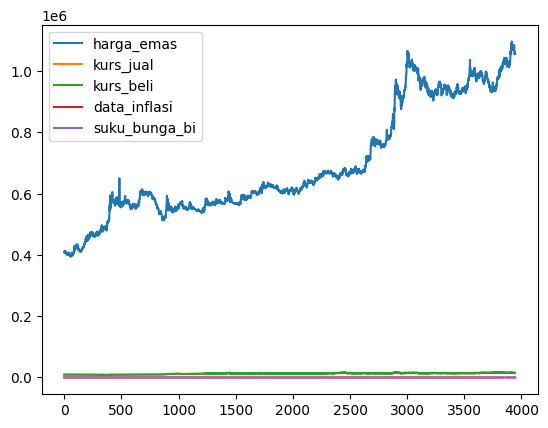

In [35]:
tabel_emas_kurs_inflasi_interest.plot()

## Plot Data

In [36]:
tabel_emas_multi_pycaret = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_multi_pycaret.tanggal = pd.to_datetime(tabel_emas_multi_pycaret.tanggal)
tabel_emas_multi_pycaret.tanggal = tabel_emas_multi_pycaret.tanggal.dt.to_period('B')
tabel_emas_multi_pycaret = tabel_emas_multi_pycaret.drop_duplicates('tanggal')
tabel_emas_multi_pycaret = tabel_emas_multi_pycaret.set_index('tanggal')
print(tabel_emas_multi_pycaret.isna().sum())

# idx = pd.period_range(min(tabel_emas_pycaret.index), max(tabel_emas_pycaret.index))
# tabel_emas_pycaret = tabel_emas_pycaret.reindex(idx, fill_value=np.nan)
# knnimp = KNNImputer()

# kol_tab_pyc = tabel_emas_pycaret.columns.tolist()
# tabel_emas_pycaret = knnimp.fit_transform(tabel_emas_pycaret)
# tabel_emas_pycaret = pd.DataFrame(tabel_emas_pycaret,columns=kol_tab_pyc)
# tabel_emas_pycaret = tabel_emas_pycaret.set_index(idx)
# tabel_emas_pycaret.plot()

harga_emas         0
kurs_jual        419
kurs_beli        419
data_inflasi      21
suku_bunga_bi      0
dtype: int64


In [37]:
tabel_emas_multi_pycaret.index.tolist()[0]

Period('2010-01-04', 'B')

In [38]:
tanggal_tabel_emas = list(map(lambda x: x.date(),tabel_emas_multi_pycaret.index.to_timestamp().tolist()))
print(tanggal_tabel_emas[:5])

[datetime.date(2010, 1, 4), datetime.date(2010, 1, 5), datetime.date(2010, 1, 6), datetime.date(2010, 1, 7), datetime.date(2010, 1, 8)]


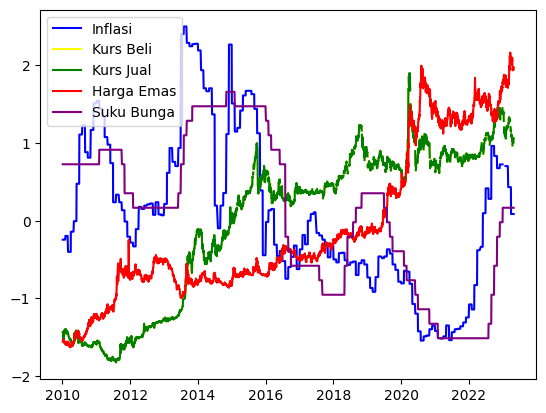

In [39]:
from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()
fig, ax = plt.subplots()
ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["data_inflasi"]]),
        label="Inflasi",color="blue")

ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["kurs_beli"]]),
        label="Kurs Beli",color="yellow")

ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["kurs_jual"]]),
        label="Kurs Jual",color="green")

ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["harga_emas"]]),
        label="Harga Emas",color="red")

ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
        std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["suku_bunga_bi"]]),
        label="Suku Bunga",color="purple")

plt.legend()
plt.show()

# ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
#         std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["new_cases"]]),
#         label="Kasus baru Covid",color="cyan")

# ax.plot(tabel_emas_kurs_inflasi_interest.tanggal,
#         std_sc.fit_transform(tabel_emas_kurs_inflasi_interest[["new_deaths"]]),
#         label="Kematian Baru Covid",color="magenta")

Ada Beberapa kesimpulan dari grafik ini
* Ada pengaruh antara Harga Emas dan Kurs Jual
* Ada Pengaruh antara harga emas dan inflasi pada tahun 2010 hingga 2017
* Tetapi, ada hal yang berpengaruh negatif pada inflasi dari 2017 hingga januari 2022
* kemunkinan kurang berpengaruh antara inflasi dengan kurs jual
* kurs jual dan kurs beli memiliki kesamaan grafik , maka mereka cenderung menyatu

## Plot Norm

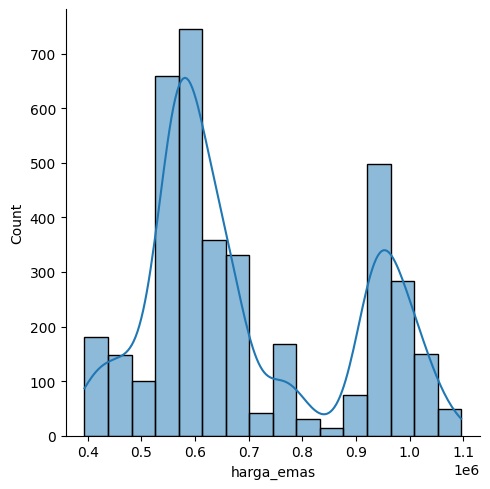

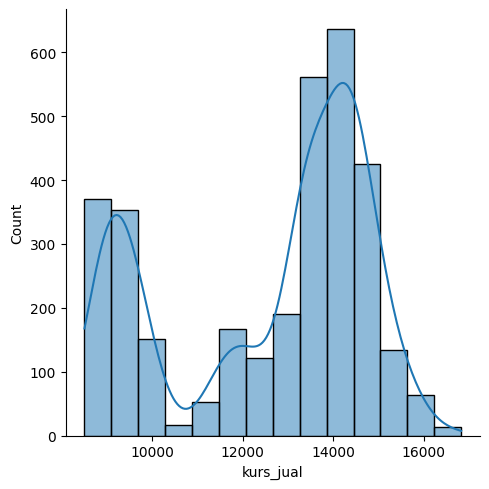

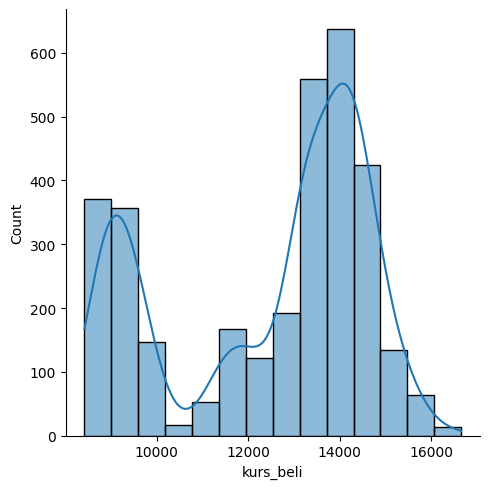

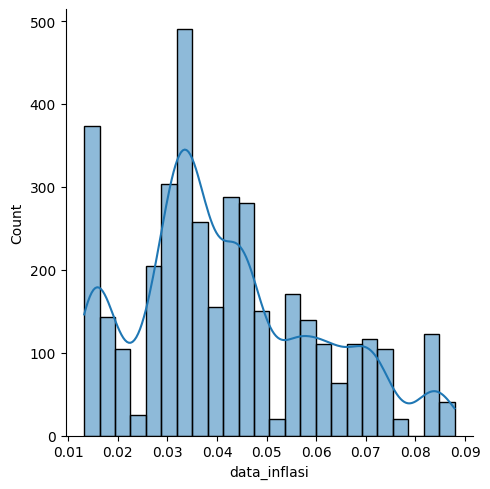

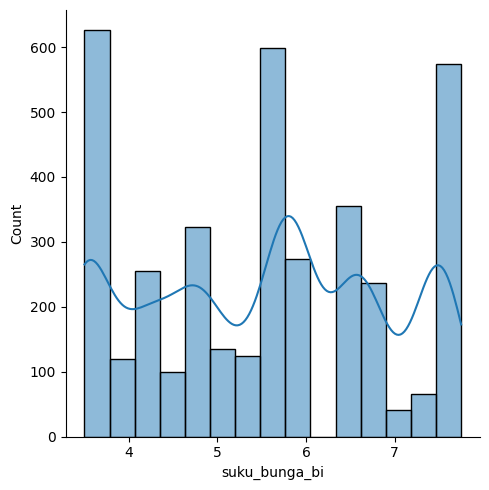

In [40]:
import seaborn as sns
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="harga_emas", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="kurs_jual", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="kurs_beli", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="data_inflasi", kde=True)
sns.displot(data=tabel_emas_kurs_inflasi_interest, x="suku_bunga_bi", kde=True)
# sns.displot(data=tabel_emas_kurs_inflasi_interest, x="new_cases", kde=True)
# sns.displot(data=tabel_emas_kurs_inflasi_interest, x="new_deaths", kde=True)

### Sebaran Data
* Harga Emas memiliki distribusi Bimodal
* Kurs Beli Dollar memiliki distribusi Bimodal
* Kurs Jual Dollar memiliki distribusi Bimodal
* Data Inflasi cenderung memiliki distribusi normal
* Suku Bunga BI cenderung mendekati distribusi banyak modal

## Stationary Analysis

In [41]:
tabel_emas_kurs_inflasi_interest.isna().sum()

tanggal            0
harga_emas         0
kurs_jual        571
kurs_beli        571
data_inflasi      31
suku_bunga_bi      0
dtype: int64

harga_emas         0
kurs_jual        571
kurs_beli        571
data_inflasi      31
suku_bunga_bi      0
dtype: int64
harga_emas       0
kurs_jual        0
kurs_beli        0
data_inflasi     0
suku_bunga_bi    0
dtype: int64


<AxesSubplot: xlabel='tanggal'>

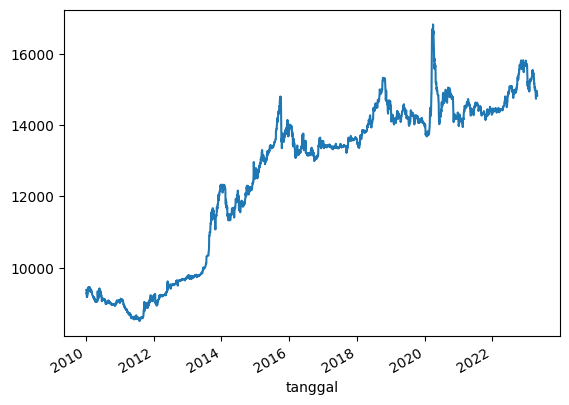

In [42]:
tabel_emas_kurs_inflasi_interest_coba = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_kurs_inflasi_interest_coba = tabel_emas_kurs_inflasi_interest_coba.set_index('tanggal')
print(tabel_emas_kurs_inflasi_interest_coba.isna().sum())

tabel_emas_kurs_inflasi_interest_coba.index = pd.to_datetime(tabel_emas_kurs_inflasi_interest_coba.index)
tabel_emas_kurs_inflasi_interest_coba = tabel_emas_kurs_inflasi_interest_coba.interpolate(method='time')
print(tabel_emas_kurs_inflasi_interest_coba.isna().sum())
tabel_emas_kurs_inflasi_interest_coba.kurs_jual.plot()


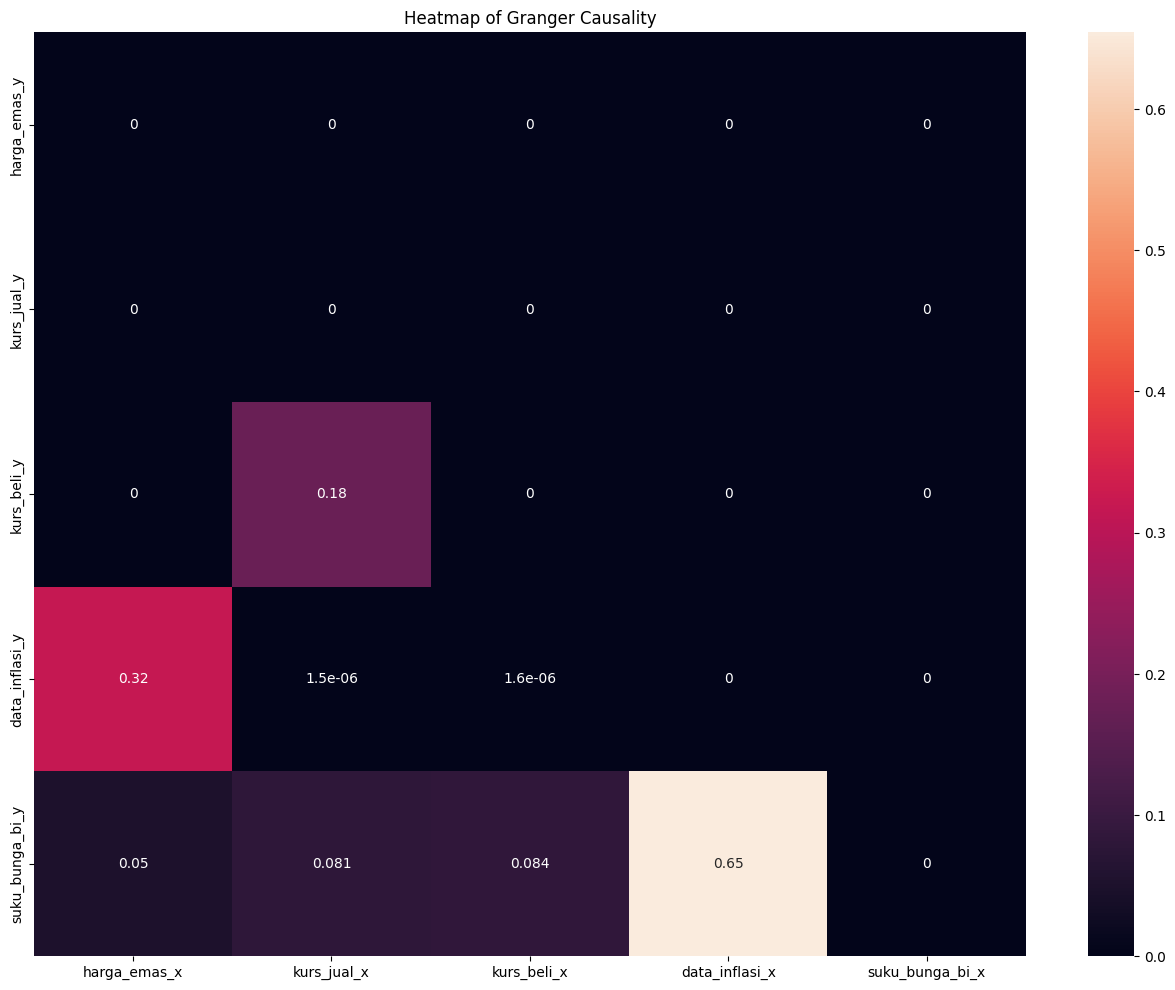

In [43]:
tabel_emas_kurs_inflasi_interest_gr = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_kurs_inflasi_interest_gr = tabel_emas_kurs_inflasi_interest_gr.interpolate()
min_lag_df,test_result_lag  = granger_causality_matrix(tabel_emas_kurs_inflasi_interest_gr,
                                        tabel_emas_kurs_inflasi_interest_gr.drop('tanggal',axis=1).columns.tolist(),
                                        maxlag=100)
# print(f'min_lag_df\n{min_lag_df}\n')
# print(f'test_result_lag\n{test_result_lag}')


plt.figure(figsize=(16, 12))
sns.heatmap(test_result_lag,
            annot=True,
           ).set(title='Heatmap of Granger Causality')
plt.savefig('Heatmap of Granger Causality.png')
# 2menit

In [44]:
from statsmodels.tsa.stattools import pacf,acf
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

# pacfku = pacf(tabel_emas_kurs_inflasi_interest['harga_emas'],nlags=1648)
acfku = acf(tabel_emas_kurs_inflasi_interest['harga_emas'],nlags=3298)

data_acf = pd.DataFrame({'acf':acfku})
print(data_acf.sort_values('acf')[2174:2176])

# percobaan = tabel_emas_kurs_inflasi_interest[['tanggal','harga_emas']]
# result = seasonal_decompose(percobaan)
# result

           acf
1124  0.075374
1123  0.075961


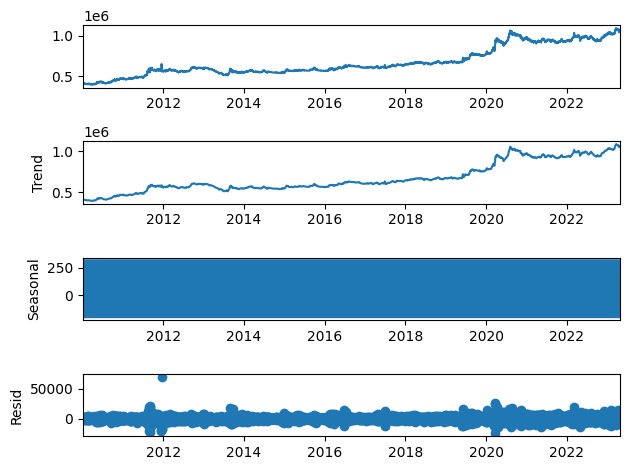

In [45]:
percobaan = tabel_emas_kurs_inflasi_interest[['tanggal','harga_emas']]
percobaan.tanggal = pd.to_datetime(percobaan.tanggal)
percobaan = percobaan.set_index('tanggal')
percobaan = percobaan.asfreq('B')
percobaan = percobaan.interpolate(method='spline',order=5,axis=0)
result = seasonal_decompose(percobaan,)
result.plot()
plt.show()

In [46]:
# from statsforecast.models import (       
#         MSTL,
#         AutoARIMA,
#         AutoETS,
#         HoltWinters,
#         HistoricAverage,
#         AutoCES,
#         AutoTheta,
# )
# from statsforecast import StatsForecast

# from neuralforecast.auto import AutoNHITS


# tabel_emas_kurs_inflasi_interest_uniq = tabel_emas_kurs_inflasi_interest.copy()
# tabel_emas_kurs_inflasi_interest_uniq['unique_id'] = 0
# tabel_emas_kurs_inflasi_interest_uniq['ds'] = tabel_emas_kurs_inflasi_interest_uniq['tanggal']
# tabel_emas_kurs_inflasi_interest_uniq['y'] = tabel_emas_kurs_inflasi_interest_uniq['harga_emas']
# tabel_emas_kurs_inflasi_interest_uniq = tabel_emas_kurs_inflasi_interest_uniq.drop(['harga_emas','tanggal'],axis=1)

# cobain = tabel_emas_kurs_inflasi_interest_uniq[['unique_id','ds','y']]


# y_train = cobain[:int(len(cobain)*0.8)]
# y_test = cobain[int(len(cobain)*0.8):]

# modelan = StatsForecast(models=[AutoARIMA(),
#                                 AutoETS(),
#                                 HoltWinters(season_length=7),
#                                 HistoricAverage(),
#                                 AutoCES(),
#                                 AutoTheta(),
#                                 ],
#                         freq='B')

# modelan.fit(df=y_train)
# y_predict = modelan.predict(h=len(y_test))

# print(y_predict.columns)

# plt.plot(y_test.ds,y_test.y,label='Actual')
# plt.plot(y_predict.ds,y_predict.AutoARIMA,label='AutoARIMA')
# plt.plot(y_predict.ds,y_predict.HoltWinters  ,label='HoltWinters')
# plt.plot(y_predict.ds,y_predict.AutoETS  ,label='AutoETS')
# plt.plot(y_predict.ds,y_predict.CES  ,label='CES')
# plt.plot(y_predict.ds,y_predict.AutoTheta  ,label='AutoTheta')

# plt.legend()
# plt.show()

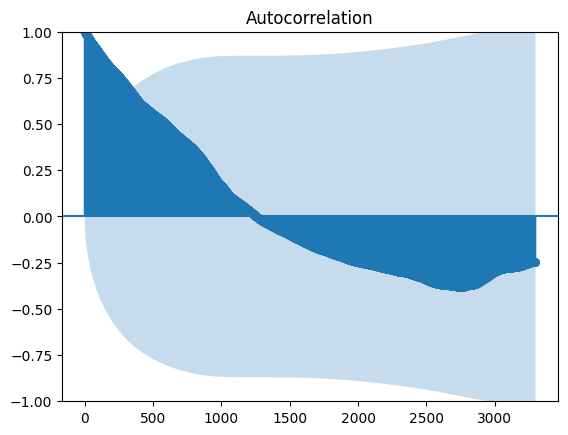

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(tabel_emas_kurs_inflasi_interest['harga_emas'],lags=3298)
# plot_acf(tabel_emas_kurs_inflasi_interest_covid['harga_emas'],lags=)
plt.show()

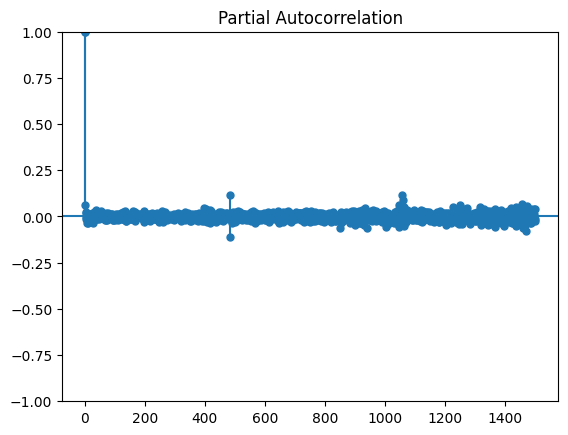

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(tabel_emas_kurs_inflasi_interest['harga_emas'],lags=1500)
plt.show()

In [49]:
# from statsforecast.adapters.prophet import AutoARIMAProphet
# model_arprophet = AutoARIMAProphet()
# tabel_emas_arpr = tabel_emas_kurs_inflasi_interest.copy()
# tabel_emas_arpr.tanggal = pd.to_datetime(tabel_emas_arpr.tanggal)
# tabel_emas_arpr.tanggal = tabel_emas_arpr.tanggal.dt.to_period('B')
# tabel_emas_arpr = tabel_emas_arpr.drop_duplicates('tanggal')
# tabel_emas_arpr = tabel_emas_arpr.set_index('tanggal')

# idx = pd.period_range(min(tabel_emas_arpr.index), max(tabel_emas_arpr.index))
# tabel_emas_arpr = tabel_emas_arpr.reindex(idx, fill_value=np.nan)
# tabel_emas_arpr = tabel_emas_arpr.reset_index()
# tabel_emas_arpr = tabel_emas_arpr[['index','harga_emas']]
# tabel_emas_arpr.columns = ['ds','y']
# tabel_emas_arpr.ds = pd.to_datetime(tabel_emas_arpr.ds.astype(str))
# model_arprophet.add_country_holidays('ID')
# model_arprophet.fit(tabel_emas_arpr)
# future = model_arprophet.make_future_dataframe(365)
# forecast = model_arprophet.predict(future)
# fig = model_arprophet.plot(forecast)

# Pycaret

In [50]:
model_pakai_ts = ['naive', 'grand_means', 'snaive', 'prophet', 'lr_cds_dt','arima','auto_arima',
               'en_cds_dt', 'ridge_cds_dt', 'lasso_cds_dt', 'lar_cds_dt',
               'llar_cds_dt', 'br_cds_dt', 'huber_cds_dt', 'par_cds_dt', 
               'omp_cds_dt', 'knn_cds_dt', 'dt_cds_dt', 'rf_cds_dt','et_cds_dt',
               'gbr_cds_dt', 'ada_cds_dt', 'xgboost_cds_dt', 'lightgbm_cds_dt', 
               'catboost_cds_dt']

In [51]:
tabel_emas_kurs_inflasi_interest.describe()

harga_emas     kurs_jual     kurs_beli  data_inflasi  suku_bunga_bi
count  3.827000e+03   3256.000000   3256.000000   3796.000000    3827.000000
mean   6.955277e+05  12573.524748  12448.376692      0.041688       5.525281
std    1.849930e+05   2232.778886   2210.570333      0.018477       1.339734
min    3.940000e+05   8502.000000   8418.000000      0.013200       3.500000
25%    5.660000e+05   9789.000000   9691.000000      0.030000       4.250000
50%    6.210000e+05  13405.000000  13271.000000      0.037900       5.750000
75%    9.220000e+05  14330.550000  14188.175000      0.054700       6.500000
max    1.096000e+06  16824.710000  16657.300000      0.087900       7.750000

## Pycaret Uni All Models

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting               Value  
0                                         3475.0  
1                                            0.0  
2                                  674525.248148  
3                                   608870.99531  
4                                  178454.921414  
5                             31846158976.722122  
6                                      -0.703589  
7                                       0.710449  
8                                          770.0  
9   {'alpha': 0.05, 'K': 24}        79811.537083  
10  {'alpha': 0.05, 'K': 48}       154990.782834  
11  {'alpha': 0.05, 'K': 24}                 0.0  
12  {'alpha': 0.05, 'K': 48}                 0.0  
13  {'alpha': 0.05, 'K': 24}               False  
14  {'alpha': 0.05, 'K': 48}               False  
15           {'alpha': 0.05}               False  
16           {'alpha': 0.05}            0.934811  
17           {'alpha': 0.05}           -0.230313  
18           {'alpha': 0.05}           -3.432242  
19           {'alpha': 0.05}           -2.862376  
20           {'alpha': 0.05}           -2.567215  
21           {'alpha': 0.05}               False  
22           {'alpha': 0.05}                0.01  
23           {'alpha': 0.05}            1.505597  
24           {'alpha': 0.05}               0.119  
25           {'alpha': 0.05}               0.146  
26           {'alpha': 0.05}               0.176  
27           {'alpha': 0.05}               0.216  
28           {'alpha': 0.05}               False  
29           {'alpha': 0.05}                 0.0

<AxesSubplot: xlabel='tanggal'>

harga_emas
tanggal               
2010-01-04    408000.0
2010-01-05    410000.0
2010-01-06    410000.0
2010-01-07    412000.0
2010-01-08    410000.0

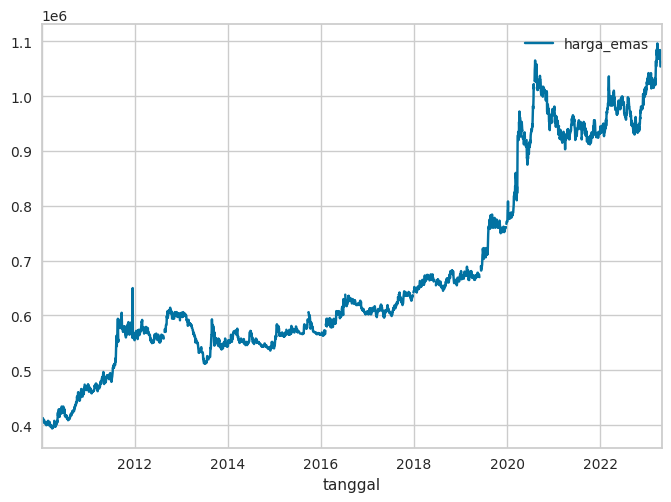

In [52]:
from pycaret.time_series import *

tabel_emas_uni_pycaret = tabel_emas.copy()
tabel_emas_uni_pycaret.tanggal = pd.to_datetime(tabel_emas_uni_pycaret.tanggal)
tanggal_tabel_emas_uni_pycaret = pd.date_range(tabel_emas_uni_pycaret.tanggal[0],
                                              tabel_emas_uni_pycaret.tanggal[tabel_emas_uni_pycaret.shape[0]-1],
                                              freq='B')

tanggal_tabel_emas_uni_pycaret = pd.DataFrame(index=tanggal_tabel_emas_uni_pycaret)
tanggal_tabel_emas_uni_pycaret.index.name = 'tanggal'

tabel_emas_uni_pycaret = tabel_emas_uni_pycaret.set_index('tanggal')
tabel_emas_uni_pycaret = tanggal_tabel_emas_uni_pycaret.merge(tabel_emas_uni_pycaret,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True,
                                                             )

pycaret_time_series_uni_all = TSForecastingExperiment()
pycaret_time_series_uni_all.setup(data=tabel_emas_uni_pycaret,
            target='harga_emas',
            numeric_imputation_target='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            #transform_target="box-cox",
            fold=3,
            fh=730,
            session_id=42,
            fe_target_rr = [Catch22()]
            )
display(pycaret_time_series_uni_all.check_stats())
display(tabel_emas_uni_pycaret.plot())
display(tabel_emas_uni_pycaret.head())

In [53]:
model_ts = pycaret_time_series_uni_all.models().index.tolist()
try:
    model_ts.remove('arima')
except:
    pass

try:
    model_ts.remove('auto_arima')
except:
    pass

try:
    model_ts.remove('ets')
except:
    pass

try:
    model_ts.remove('tbats')
except:
    pass
try:
    model_ts.remove('bats')
except:
    pass

In [54]:
# model_pycaret_uni_all = pycaret_time_series_uni_all.compare_models(include=model_ts)
model_pycaret_uni_all = pycaret_time_series_uni_all.compare_models(include=model_ts,budget_time=30)
model_pycaret_uni_all

Processing:   0%|          | 0/109 [00:00<?, ?it/s]

ExponentialSmoothing(seasonal='mul', sp=261, trend='add')

In [55]:
best_model_uni_all = pycaret_time_series_uni_all.tune_model(model_pycaret_uni_all)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    5.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.1s finished


In [56]:
pycaret_time_series_uni_all.plot_model(model_pycaret_uni_all)

In [57]:
pycaret_time_series_uni_all.plot_model(model_pycaret_uni_all,plot="decomp")

In [58]:
pycaret_time_series_uni_all.plot_model(model_pycaret_uni_all,plot="decomp_stl")

In [59]:
pycaret_time_series_uni_all.plot_model(model_pycaret_uni_all,plot="diagnostics")

In [60]:
final_model_uni_all = pycaret_time_series_uni_all.finalize_model(best_model_uni_all)
final_model_uni_all

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42))])),
                                                               ('model',
                                                                ExponentialSmoothing(seasonal='add',
                                                                                     sp=261,
                                                                                     trend='add',
                                                                                     use_boxcox=False))]))])

<AxesSubplot: >

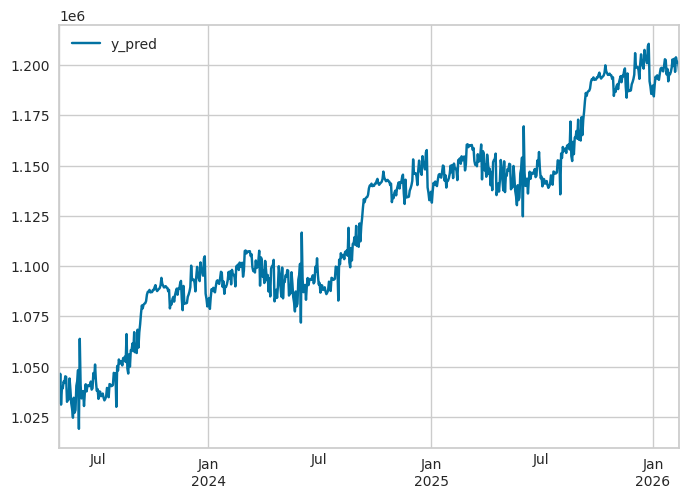

In [61]:
hasil_ts_uni_all = pycaret_time_series_uni_all.predict_model(final_model_uni_all,fh=730)
hasil_ts_uni_all.plot()

In [62]:
hasil_ts_uni_all.columns = ['harga_emas']
hasil_ts_uni_all.head(10)

harga_emas
2023-05-01  1.032023e+06
2023-05-02  1.046469e+06
2023-05-03  1.031138e+06
2023-05-04  1.039469e+06
2023-05-05  1.039235e+06
2023-05-08  1.042626e+06
2023-05-09  1.041896e+06
2023-05-10  1.045218e+06
2023-05-11  1.044931e+06
2023-05-12  1.032546e+06

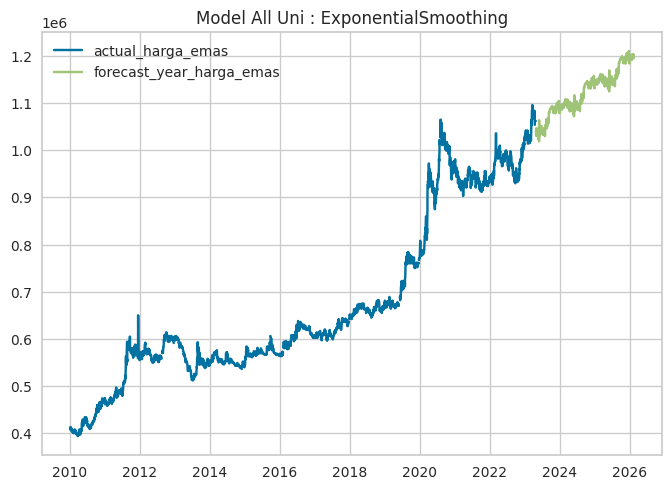

In [63]:
try:
    nama_model_uni_all = final_model_uni_all.get_params()['forecaster__model'].__class__.__name__
except:
    nama_model_uni_all = ''
    pass
    
plt.plot(tabel_emas_uni_pycaret.index,tabel_emas_uni_pycaret.harga_emas,label='actual_harga_emas')
plt.plot(hasil_ts_uni_all.index,hasil_ts_uni_all.harga_emas,label='forecast_year_harga_emas')
plt.title(f'Model All Uni : {nama_model_uni_all}')
plt.legend()
plt.show()

## Pycaret Prophet Uni

In [64]:
from pycaret.time_series import *

tabel_emas_uni_pycaret_prophet = tabel_emas.copy()
tabel_emas_uni_pycaret_prophet.tanggal = pd.to_datetime(tabel_emas_uni_pycaret_prophet.tanggal)
tanggal_tabel_emas_uni_pycaret_prophet = pd.date_range(tabel_emas_uni_pycaret_prophet.tanggal[0],
                                              tabel_emas_uni_pycaret_prophet.tanggal[tabel_emas_uni_pycaret_prophet.shape[0]-1],
                                              freq='B')

tanggal_tabel_emas_uni_pycaret_prophet = pd.DataFrame(index=tanggal_tabel_emas_uni_pycaret_prophet)
tanggal_tabel_emas_uni_pycaret_prophet.index.name = 'tanggal'

tabel_emas_uni_pycaret_prophet = tabel_emas_uni_pycaret_prophet.set_index('tanggal')
tabel_emas_uni_pycaret_prophet = tanggal_tabel_emas_uni_pycaret_prophet.merge(tabel_emas_uni_pycaret_prophet,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True,
                                                             )

pycaret_prophet_uni = TSForecastingExperiment()
pycaret_prophet_uni.setup(data=tabel_emas_uni_pycaret_prophet,
            target='harga_emas',
            numeric_imputation_target='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            session_id=42,
            # fe_target_rr=[Catch22(catch24=True, outlier_norm=True)],
            # transform_target="box-cox",
            fold=3,
            fh=730)
pycaret_prophet_uni.check_stats()

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting               Value  
0                                         3475.0  
1                                            0.0  
2                                  674525.248148  
3                                   608870.99531  
4                                  178454.921414  
5                             31846158976.722122  
6                                      -0.703589  
7                                       0.710449  
8                                          770.0  
9   {'alpha': 0.05, 'K': 24}        79811.537083  
10  {'alpha': 0.05, 'K': 48}       154990.782834  
11  {'alpha': 0.05, 'K': 24}                 0.0  
12  {'alpha': 0.05, 'K': 48}                 0.0  
13  {'alpha': 0.05, 'K': 24}               False  
14  {'alpha': 0.05, 'K': 48}               False  
15           {'alpha': 0.05}               False  
16           {'alpha': 0.05}            0.934811  
17           {'alpha': 0.05}           -0.230313  
18           {'alpha': 0.05}           -3.432242  
19           {'alpha': 0.05}           -2.862376  
20           {'alpha': 0.05}           -2.567215  
21           {'alpha': 0.05}               False  
22           {'alpha': 0.05}                0.01  
23           {'alpha': 0.05}            1.505597  
24           {'alpha': 0.05}               0.119  
25           {'alpha': 0.05}               0.146  
26           {'alpha': 0.05}               0.176  
27           {'alpha': 0.05}               0.216  
28           {'alpha': 0.05}               False  
29           {'alpha': 0.05}                 0.0

In [65]:
model_pycaret_prophet_uni = pycaret_prophet_uni.create_model('prophet')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [66]:
model_pycaret_prophet_uni_tuned = pycaret_prophet_uni.tune_model(model_pycaret_prophet_uni)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.6s finished


In [67]:
pycaret_prophet_uni.plot_model(model_pycaret_prophet_uni_tuned)

In [68]:
pycaret_prophet_uni.plot_model(model_pycaret_prophet_uni_tuned,plot='diagnostics')

In [69]:
pycaret_prophet_uni.plot_model(model_pycaret_prophet_uni_tuned,plot='decomp_stl')

In [70]:
model_pycaret_prophet_uni_tuned_finalized = pycaret_prophet_uni.finalize_model(model_pycaret_prophet_uni_tuned)
model_pycaret_prophet_uni_tuned_finalized

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42))])),
                                                               ('model',
                                                                ProphetPeriodPatched(changepoint_prior_scale=0.016439324494196616,
                                                                                     holidays_prior_scale=0.01095960453692584,
                                                                                     seasonality_prior_scale=7.886714129990491))]))])

              harga_emas
2023-05-01  9.905190e+05
2023-05-02  9.893549e+05
2023-05-03  9.887258e+05
2023-05-04  9.882017e+05
2023-05-05  9.873288e+05
...                  ...
2026-02-09  1.046218e+06
2026-02-10  1.045873e+06
2026-02-11  1.046014e+06
2026-02-12  1.046201e+06
2026-02-13  1.045977e+06

[730 rows x 1 columns]


<AxesSubplot: >

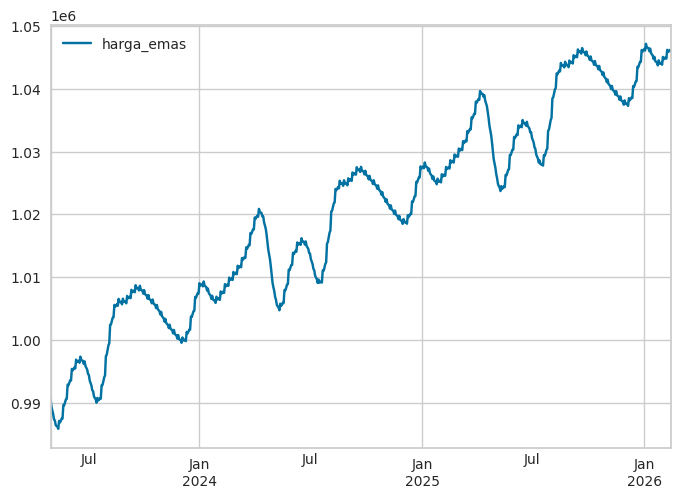

In [71]:
hasil_ts_uni_prophet =  pycaret_prophet_uni.predict_model(model_pycaret_prophet_uni_tuned_finalized,fh=730)
hasil_ts_uni_prophet.columns = ['harga_emas']
print(hasil_ts_uni_prophet)
hasil_ts_uni_prophet.plot()

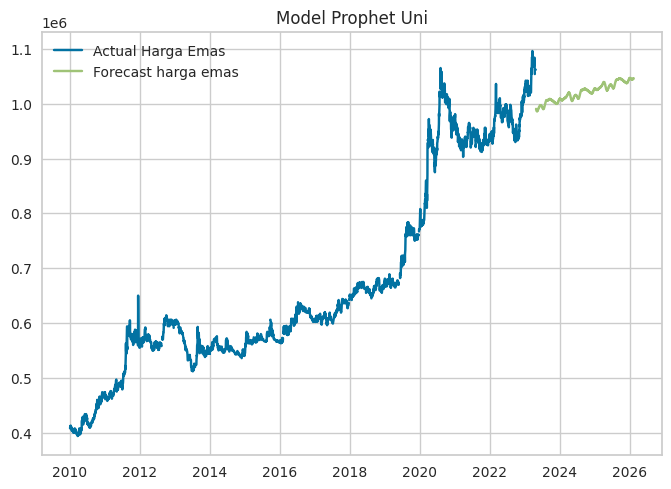

In [72]:
plt.plot(tabel_emas_uni_pycaret_prophet.index.to_period().to_timestamp(),tabel_emas_uni_pycaret_prophet.harga_emas,label='Actual Harga Emas')
plt.plot(hasil_ts_uni_prophet.index.to_timestamp(),hasil_ts_uni_prophet.harga_emas,label='Forecast harga emas')
plt.title('Model Prophet Uni')
plt.legend()
plt.show()

## Pycaret Multi

In [73]:
from datetime import date

tabel_emas_kurs_inflasi_interest[tabel_emas_kurs_inflasi_interest.tanggal==date(2010,2,26)]

Empty DataFrame
Columns: [tanggal, harga_emas, kurs_jual, kurs_beli, data_inflasi, suku_bunga_bi]
Index: []

In [74]:
model_pakai_ts = ['naive', 'grand_means', 'snaive', 'prophet', 'lr_cds_dt',
               'en_cds_dt', 'ridge_cds_dt', 'lasso_cds_dt', 'lar_cds_dt',
               'llar_cds_dt', 'br_cds_dt', 'huber_cds_dt', 'par_cds_dt', 
               'omp_cds_dt', 'knn_cds_dt', 'dt_cds_dt', 'rf_cds_dt','et_cds_dt',
               'gbr_cds_dt', 'ada_cds_dt', 'xgboost_cds_dt', 'lightgbm_cds_dt', 
               'catboost_cds_dt']

In [75]:
from sklearn.impute import KNNImputer
from pycaret.time_series import *

tabel_emas_mul_pycaret_all = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_mul_pycaret_all.tanggal = pd.to_datetime(tabel_emas_mul_pycaret_all.tanggal)
tanggal_tabel_emas_mul_pycaret_all = pd.date_range(tabel_emas_mul_pycaret_all.tanggal[0],
                                              tabel_emas_mul_pycaret_all.tanggal[tabel_emas_mul_pycaret_all.shape[0]-1],
                                              freq='B')

tanggal_tabel_emas_mul_pycaret_all = pd.DataFrame(index=tanggal_tabel_emas_mul_pycaret_all)
tanggal_tabel_emas_mul_pycaret_all.index.name = 'tanggal'

tabel_emas_mul_pycaret_all = tabel_emas_mul_pycaret_all.set_index('tanggal')
tabel_emas_mul_pycaret_all = tanggal_tabel_emas_mul_pycaret_all.merge(tabel_emas_mul_pycaret_all,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True,
                                                             )
# print(tabel_emas_pycaret.isna().sum())

pycaret_mul_time_series_all = TSForecastingExperiment()
pycaret_mul_time_series_all.setup(data=tabel_emas_mul_pycaret_all,session_id=42,
            target='harga_emas',
            numeric_imputation_target='drift',
            numeric_imputation_exogenous='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            transform_target="box-cox",
            transform_exogenous="box-cox",
            fold=3,
            fh=730)

pycaret_mul_time_series_all.check_stats()

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting          Value  
0                                    3383.0  
1                                       0.0  
2                                  1.497207  
3                                  1.497201  
4                                  0.000032  
5                                       0.0  
6                                  -0.46972  
7                                  0.031158  
8                                     737.0  
9   {'alpha': 0.05, 'K': 24}   77114.551244  
10  {'alpha': 0.05, 'K': 48}  149520.326653  
11  {'alpha': 0.05, 'K': 24}            0.0  
12  {'alpha': 0.05, 'K': 48}            0.0  
13  {'alpha': 0.05, 'K': 24}          False  
14  {'alpha': 0.05, 'K': 48}          False  
15           {'alpha': 0.05}          False  
16           {'alpha': 0.05}       0.575884  
17           {'alpha': 0.05}      -1.413299  
18           {'alpha': 0.05}      -3.432296  
19           {'alpha': 0.05}        -2.8624  
20           {'alpha': 0.05}      -2.567228  
21           {'alpha': 0.05}          False  
22           {'alpha': 0.05}           0.01  
23           {'alpha': 0.05}       0.708484  
24           {'alpha': 0.05}          0.119  
25           {'alpha': 0.05}          0.146  
26           {'alpha': 0.05}          0.176  
27           {'alpha': 0.05}          0.216  
28           {'alpha': 0.05}          False  
29           {'alpha': 0.05}            0.0

In [76]:
model_pakai_ts = pycaret_mul_time_series_all.models().index.tolist()
try:
    model_pakai_ts.remove('arima')
except:
    pass

try:
    model_pakai_ts.remove('auto_arima')
except:
    pass

try:
    model_pakai_ts.remove('ets')
except:
    pass

try:
    model_pakai_ts.remove('tbats')
except:
    pass

try:
    model_pakai_ts.remove('bats')
except:
    pass

In [77]:
model_mul_pycaret_all = pycaret_mul_time_series_all.compare_models(include=model_pakai_ts,budget_time=30)
model_mul_pycaret_all_tuned = pycaret_mul_time_series_all.tune_model(model_mul_pycaret_all,
                                      search_algorithm='random')

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.6min finished


In [78]:
pycaret_mul_time_series_all.plot_model(model_mul_pycaret_all_tuned)

In [79]:
pycaret_mul_time_series_all.plot_model(model_mul_pycaret_all_tuned,plot="diagnostics")

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [80]:
pycaret_mul_time_series_all.plot_model(model_mul_pycaret_all_tuned,plot="decomp_stl")

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [81]:
model_mul_pycaret_all_tuned_finalized = pycaret_mul_time_series_all.finalize_model(model_mul_pycaret_all_tuned)
model_mul_pycaret_all_tuned_finalized

ForecastingPipeline(steps=[('transformer_exogenous',
                            TransformerPipeline(steps=[('numerical_imputer',
                                                        Imputer(random_state=42)),
                                                       ('transformer',
                                                        ColumnwiseTransformer(transformer=BoxCoxTransformer()))])),
                           ('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42)),
                                                                                           ('transformer',
                                                                                            BoxCoxTransformer())])),
                                                               ('model',
                                                                BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [10,
                                                                                                                                        9,
                                                                                                                                        8,
                                                                                                                                        7,
                                                                                                                                        6,
                                                                                                                                        5,
                                                                                                                                        4,
                                                                                                                                        3,
                                                                                                                                        2,
                                                                                                                                        1]},
                                                                                                                   n_jobs=1)],
                                                                                    regressor=GradientBoostingRegressor(random_state=42),
                                                                                    sp=10))]))])

# Pycaret For Exogenous

In [82]:
kolom_exo = tabel_emas_mul_pycaret_all.columns.tolist()
kolom_exo.remove('harga_emas')
kolom_exo

['kurs_jual', 'kurs_beli', 'data_inflasi', 'suku_bunga_bi']

In [83]:
kolom_exo = tabel_emas_mul_pycaret_all.columns.tolist()
kolom_exo.remove('harga_emas')

exog_exps = []
exog_models = []
for exog_var in kolom_exo:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=tabel_emas_mul_pycaret_all[exog_var], fh=730,
        numeric_imputation_target="drift", 
        session_id=42,
        transform_target="box-cox",
        max_sp_to_consider=None,
        num_sps_to_use=-1,
    )

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    display(exog_exp.check_stats())
    best = exog_exp.compare_models(include=model_pakai_ts,sort="RMSE",budget_time=30)
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

# Step 2: Get future predictions for exog variables ----
future_exog_all = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog_all = pd.concat(future_exog_all, axis=1)
future_exog_all.columns = kolom_exo
future_exog_all.head()

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting                     Value  
0                                               3383.0  
1                                                  0.0  
2                                  112983101364.641647  
3                                  127223595279.314743  
4                                   48399449234.906151  
5                             2342506686242257633280.0  
6                                             -1.20424  
7                                            -0.254968  
8                                               2449.0  
9   {'alpha': 0.05, 'K': 24}              76805.523054  
10  {'alpha': 0.05, 'K': 48}             148399.968909  
11  {'alpha': 0.05, 'K': 24}                       0.0  
12  {'alpha': 0.05, 'K': 48}                       0.0  
13  {'alpha': 0.05, 'K': 24}                     False  
14  {'alpha': 0.05, 'K': 48}                     False  
15           {'alpha': 0.05}                     False  
16           {'alpha': 0.05}                  0.755908  
17           {'alpha': 0.05}                 -0.992725  
18           {'alpha': 0.05}                 -3.432294  
19           {'alpha': 0.05}                 -2.862399  
20           {'alpha': 0.05}                 -2.567227  
21           {'alpha': 0.05}                     False  
22           {'alpha': 0.05}                      0.01  
23           {'alpha': 0.05}                  0.947301  
24           {'alpha': 0.05}                     0.119  
25           {'alpha': 0.05}                     0.146  
26           {'alpha': 0.05}                     0.176  
27           {'alpha': 0.05}                     0.216  
28           {'alpha': 0.05}                     False  
29           {'alpha': 0.05}                       0.0

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting                     Value  
0                                               3383.0  
1                                                  0.0  
2                                  109717968847.921951  
3                                  123527281025.719604  
4                                   46999276498.455978  
5                             2208931991378316754944.0  
6                                            -1.204236  
7                                            -0.254951  
8                                               2439.0  
9   {'alpha': 0.05, 'K': 24}              76805.493142  
10  {'alpha': 0.05, 'K': 48}             148399.652879  
11  {'alpha': 0.05, 'K': 24}                       0.0  
12  {'alpha': 0.05, 'K': 48}                       0.0  
13  {'alpha': 0.05, 'K': 24}                     False  
14  {'alpha': 0.05, 'K': 48}                     False  
15           {'alpha': 0.05}                     False  
16           {'alpha': 0.05}                  0.755909  
17           {'alpha': 0.05}                 -0.992723  
18           {'alpha': 0.05}                 -3.432294  
19           {'alpha': 0.05}                 -2.862399  
20           {'alpha': 0.05}                 -2.567227  
21           {'alpha': 0.05}                     False  
22           {'alpha': 0.05}                      0.01  
23           {'alpha': 0.05}                  0.947194  
24           {'alpha': 0.05}                     0.119  
25           {'alpha': 0.05}                     0.146  
26           {'alpha': 0.05}                     0.176  
27           {'alpha': 0.05}                     0.216  
28           {'alpha': 0.05}                     False  
29           {'alpha': 0.05}                       0.0

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting         Value  
0                                   3383.0  
1                                      0.0  
2                                -1.723131  
3                                -1.730718  
4                                 0.109756  
5                                 0.012046  
6                                 -0.53547  
7                                -0.037573  
8                                    320.0  
9   {'alpha': 0.05, 'K': 24}  74129.791697  
10  {'alpha': 0.05, 'K': 48}  141937.66889  
11  {'alpha': 0.05, 'K': 24}           0.0  
12  {'alpha': 0.05, 'K': 48}           0.0  
13  {'alpha': 0.05, 'K': 24}         False  
14  {'alpha': 0.05, 'K': 48}         False  
15           {'alpha': 0.05}         False  
16           {'alpha': 0.05}      0.474386  
17           {'alpha': 0.05}      -1.61684  
18           {'alpha': 0.05}     -3.432298  
19           {'alpha': 0.05}     -2.862401  
20           {'alpha': 0.05}     -2.567228  
21           {'alpha': 0.05}         False  
22           {'alpha': 0.05}          0.01  
23           {'alpha': 0.05}       0.52776  
24           {'alpha': 0.05}         0.119  
25           {'alpha': 0.05}         0.146  
26           {'alpha': 0.05}         0.176  
27           {'alpha': 0.05}         0.216  
28           {'alpha': 0.05}         False  
29           {'alpha': 0.05}           0.0

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting          Value  
0                                    3383.0  
1                                       0.0  
2                                  5.261006  
3                                   5.36661  
4                                  1.582022  
5                                  2.502793  
6                                 -1.157343  
7                                 -0.109774  
8                                     202.0  
9   {'alpha': 0.05, 'K': 24}   76423.309559  
10  {'alpha': 0.05, 'K': 48}  150594.431803  
11  {'alpha': 0.05, 'K': 24}            0.0  
12  {'alpha': 0.05, 'K': 48}            0.0  
13  {'alpha': 0.05, 'K': 24}          False  
14  {'alpha': 0.05, 'K': 48}          False  
15           {'alpha': 0.05}          False  
16           {'alpha': 0.05}       0.730598  
17           {'alpha': 0.05}      -1.060413  
18           {'alpha': 0.05}      -3.432298  
19           {'alpha': 0.05}      -2.862401  
20           {'alpha': 0.05}      -2.567228  
21           {'alpha': 0.05}          False  
22           {'alpha': 0.05}           0.01  
23           {'alpha': 0.05}       0.806179  
24           {'alpha': 0.05}          0.119  
25           {'alpha': 0.05}          0.146  
26           {'alpha': 0.05}          0.176  
27           {'alpha': 0.05}          0.216  
28           {'alpha': 0.05}          False  
29           {'alpha': 0.05}            0.0

Processing:   0%|          | 0/97 [00:00<?, ?it/s]

kurs_jual   kurs_beli  data_inflasi  suku_bunga_bi
2022-12-22  15210.6508  15059.2805        0.0372         4.1917
2022-12-23  15255.8889  15104.0878        0.0372         4.0272
2022-12-26  15272.6923  15120.6817        0.0372         4.0463
2022-12-27  15193.7133  15042.5130        0.0372         4.0661
2022-12-28  15118.6236  14968.1897        0.0372         4.0284

<AxesSubplot: >

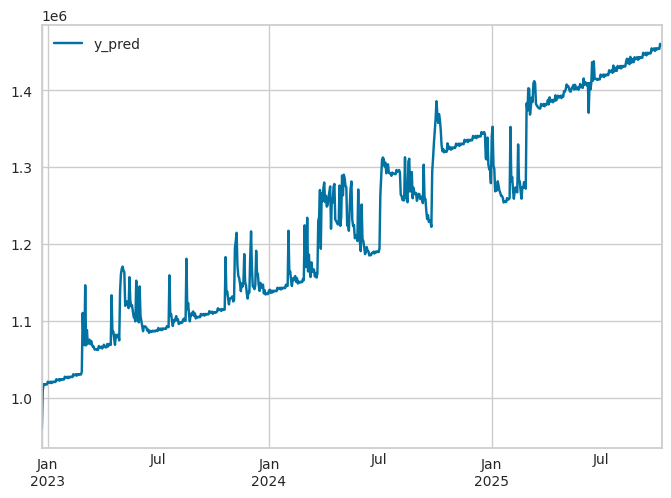

In [84]:
hasil_ts_multi_all = pycaret_mul_time_series_all.predict_model(model_mul_pycaret_all_tuned_finalized,X=future_exog_all,fh=730,)
hasil_ts_multi_all.plot()

In [85]:
hasil_ts_multi_all.rename(columns={'y_pred':'harga_emas'},inplace=True)

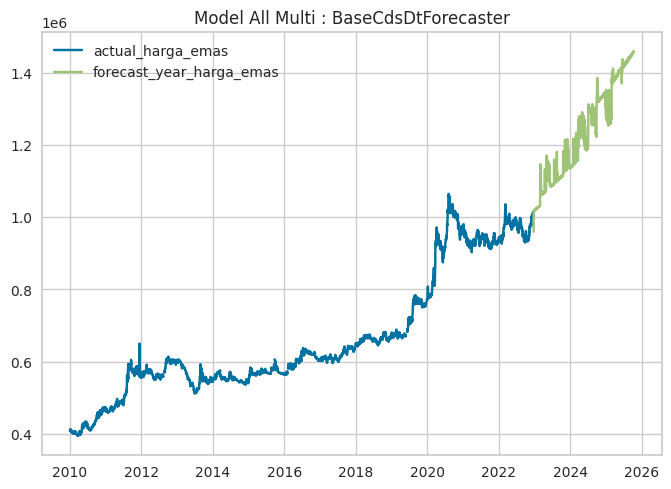

In [86]:
try:
    nama_model_multi_all = model_mul_pycaret_all_tuned_finalized.get_params()['forecaster__model'].__class__.__name__
except:
    nama_model_multi_all = ''
    pass
    

    
plt.plot(tabel_emas_mul_pycaret_all.index,tabel_emas_mul_pycaret_all.harga_emas,label='actual_harga_emas')
plt.plot(hasil_ts_multi_all.index,hasil_ts_multi_all.harga_emas,label='forecast_year_harga_emas')
plt.title(f'Model All Multi : {nama_model_multi_all}')
plt.legend()
plt.show()

# Pycaret Multi Prophet

In [87]:
from pycaret.time_series import *

tabel_emas_mul_pycaret_all_prophet = tabel_emas_kurs_inflasi_interest.copy()
tabel_emas_mul_pycaret_all_prophet.tanggal = pd.to_datetime(tabel_emas_mul_pycaret_all_prophet.tanggal)
tanggal_tabel_emas_mul_pycaret_all = pd.date_range(tabel_emas_mul_pycaret_all_prophet.tanggal[0],
                                              tabel_emas_mul_pycaret_all_prophet.tanggal[tabel_emas_mul_pycaret_all_prophet.shape[0]-1],
                                              freq='B')

tanggal_tabel_emas_mul_pycaret_all_prophet = pd.DataFrame(index=tanggal_tabel_emas_mul_pycaret_all)
tanggal_tabel_emas_mul_pycaret_all_prophet.index.name = 'tanggal'

tabel_emas_mul_pycaret_all_prophet = tabel_emas_mul_pycaret_all_prophet.set_index('tanggal')
tabel_emas_mul_pycaret_all_prophet = tanggal_tabel_emas_mul_pycaret_all_prophet.merge(tabel_emas_mul_pycaret_all_prophet,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True,
                                                             )

# idx = pd.period_range(min(tabel_emas_pycaret.index), max(tabel_emas_pycaret.index))
# tabel_emas_pycaret = tabel_emas_pycaret.reindex(idx, fill_value=np.nan)
# knnimp = KNNImputer()

# kol_tab_pyc = tabel_emas_pycaret.columns.tolist()
# tabel_emas_pycaret = knnimp.fit_transform(tabel_emas_pycaret)
# tabel_emas_pycaret = pd.DataFrame(tabel_emas_pycaret,columns=kol_tab_pyc)
# tabel_emas_pycaret = tabel_emas_pycaret.set_index(idx)
# tabel_emas_pycaret.plot()

print(100*'=')
display(tabel_emas_mul_pycaret_all_prophet.describe())
display(tabel_emas_mul_pycaret_all_prophet.head())


pycaret_time_series_all_prophet = TSForecastingExperiment()
pycaret_time_series_all_prophet.setup(data=tabel_emas_mul_pycaret_all_prophet,session_id=42,
            target='harga_emas',
            numeric_imputation_target='drift',
            numeric_imputation_exogenous='drift',
            max_sp_to_consider=None,
            num_sps_to_use=-1,
            transform_target="box-cox",
            transform_exogenous="box-cox",
            fold=2,
            fh=730)


pycaret_time_series_all_prophet.check_stats()

harga_emas     kurs_jual     kurs_beli  data_inflasi  suku_bunga_bi
count  3.198000e+03   3174.000000   3174.000000   3198.000000    3198.000000
mean   6.658024e+05  12503.910384  12379.454168      0.042886       5.637977
std    1.717761e+05   2217.877371   2195.816189      0.018696       1.337666
min    3.940000e+05   8502.000000   8418.000000      0.013200       3.500000
25%    5.590000e+05   9770.250000   9672.250000      0.031300       4.500000
50%    6.052000e+05  13395.500000  13261.500000      0.038800       5.750000
75%    7.620000e+05  14299.897500  14157.645000      0.055700       6.750000
max    1.065000e+06  16824.710000  16657.300000      0.087900       7.750000

harga_emas  kurs_jual  kurs_beli  data_inflasi  suku_bunga_bi
tanggal                                                                  
2010-01-04    408000.0     9377.0     9283.0        0.0372            6.5
2010-01-05    410000.0     9355.0     9261.0        0.0372            6.5
2010-01-06    410000.0     9355.0     9261.0        0.0372            6.5
2010-01-07    412000.0     9274.0     9182.0        0.0372            6.5
2010-01-08    410000.0     9286.0     9194.0        0.0372            6.5

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting          Value  
0                                    3383.0  
1                                       0.0  
2                                  1.497207  
3                                  1.497201  
4                                  0.000032  
5                                       0.0  
6                                  -0.46972  
7                                  0.031158  
8                                     737.0  
9   {'alpha': 0.05, 'K': 24}   77114.551244  
10  {'alpha': 0.05, 'K': 48}  149520.326653  
11  {'alpha': 0.05, 'K': 24}            0.0  
12  {'alpha': 0.05, 'K': 48}            0.0  
13  {'alpha': 0.05, 'K': 24}          False  
14  {'alpha': 0.05, 'K': 48}          False  
15           {'alpha': 0.05}          False  
16           {'alpha': 0.05}       0.575884  
17           {'alpha': 0.05}      -1.413299  
18           {'alpha': 0.05}      -3.432296  
19           {'alpha': 0.05}        -2.8624  
20           {'alpha': 0.05}      -2.567228  
21           {'alpha': 0.05}          False  
22           {'alpha': 0.05}           0.01  
23           {'alpha': 0.05}       0.708484  
24           {'alpha': 0.05}          0.119  
25           {'alpha': 0.05}          0.146  
26           {'alpha': 0.05}          0.176  
27           {'alpha': 0.05}          0.216  
28           {'alpha': 0.05}          False  
29           {'alpha': 0.05}            0.0

In [88]:
model_pycaret_all_prophet =  pycaret_time_series_all_prophet.create_model('prophet')
model_pycaret_all_prophet

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

ProphetPeriodPatched()

In [89]:
tuned_model_pycaret_all_prophet =  pycaret_time_series_all_prophet.tune_model(model_pycaret_all_prophet)
tuned_model_pycaret_all_prophet

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.2s finished


ProphetPeriodPatched(changepoint_prior_scale=0.01025350969016849,
                     holidays_prior_scale=7.114476009343417,
                     seasonality_prior_scale=2.183096839052459)

In [90]:
pycaret_time_series_all_prophet.plot_model(tuned_model_pycaret_all_prophet)

In [91]:
final_tuned_model_pycaret_all_prophet =  pycaret_time_series_all_prophet.finalize_model(tuned_model_pycaret_all_prophet)
final_tuned_model_pycaret_all_prophet

ForecastingPipeline(steps=[('transformer_exogenous',
                            TransformerPipeline(steps=[('numerical_imputer',
                                                        Imputer(random_state=42)),
                                                       ('transformer',
                                                        ColumnwiseTransformer(transformer=BoxCoxTransformer()))])),
                           ('forecaster',
                            TransformedTargetForecaster(steps=[('transformer_target',
                                                                TransformerPipeline(steps=[('numerical_imputer',
                                                                                            Imputer(random_state=42)),
                                                                                           ('transformer',
                                                                                            BoxCoxTransformer())])),
                                                               ('model',
                                                                ProphetPeriodPatched(changepoint_prior_scale=0.01025350969016849,
                                                                                     holidays_prior_scale=7.114476009343417,
                                                                                     seasonality_prior_scale=2.183096839052459))]))])

## Pycaret All prophet

In [92]:
kolom_exo = tabel_emas_mul_pycaret_all_prophet.columns.tolist()
kolom_exo.remove('harga_emas')

exog_exps = []
exog_models = []
for exog_var in kolom_exo:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=tabel_emas_mul_pycaret_all_prophet[exog_var], fh=730,
        numeric_imputation_target="drift", 
        session_id=42,
        transform_target="box-cox",
        max_sp_to_consider=None,
        num_sps_to_use=-1,
    )
    display(exog_exp.check_stats())

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    best = exog_exp.create_model("prophet")
    best = exog_exp.tune_model(best)
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)
    display(exog_exp.check_stats())
    
    
    
# Step 2: Get future predictions for exog variables ----
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = kolom_exo
future_exog.head()

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting                     Value  
0                                               3383.0  
1                                                  0.0  
2                                  112983101364.641647  
3                                  127223595279.314743  
4                                   48399449234.906151  
5                             2342506686242257633280.0  
6                                             -1.20424  
7                                            -0.254968  
8                                               2449.0  
9   {'alpha': 0.05, 'K': 24}              76805.523054  
10  {'alpha': 0.05, 'K': 48}             148399.968909  
11  {'alpha': 0.05, 'K': 24}                       0.0  
12  {'alpha': 0.05, 'K': 48}                       0.0  
13  {'alpha': 0.05, 'K': 24}                     False  
14  {'alpha': 0.05, 'K': 48}                     False  
15           {'alpha': 0.05}                     False  
16           {'alpha': 0.05}                  0.755908  
17           {'alpha': 0.05}                 -0.992725  
18           {'alpha': 0.05}                 -3.432294  
19           {'alpha': 0.05}                 -2.862399  
20           {'alpha': 0.05}                 -2.567227  
21           {'alpha': 0.05}                     False  
22           {'alpha': 0.05}                      0.01  
23           {'alpha': 0.05}                  0.947301  
24           {'alpha': 0.05}                     0.119  
25           {'alpha': 0.05}                     0.146  
26           {'alpha': 0.05}                     0.176  
27           {'alpha': 0.05}                     0.216  
28           {'alpha': 0.05}                     False  
29           {'alpha': 0.05}                       0.0

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.3s finished


Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting                     Value  
0                                               3383.0  
1                                                  0.0  
2                                  112983101364.641647  
3                                  127223595279.314743  
4                                   48399449234.906151  
5                             2342506686242257633280.0  
6                                             -1.20424  
7                                            -0.254968  
8                                               2449.0  
9   {'alpha': 0.05, 'K': 24}              76805.523054  
10  {'alpha': 0.05, 'K': 48}             148399.968909  
11  {'alpha': 0.05, 'K': 24}                       0.0  
12  {'alpha': 0.05, 'K': 48}                       0.0  
13  {'alpha': 0.05, 'K': 24}                     False  
14  {'alpha': 0.05, 'K': 48}                     False  
15           {'alpha': 0.05}                     False  
16           {'alpha': 0.05}                  0.755908  
17           {'alpha': 0.05}                 -0.992725  
18           {'alpha': 0.05}                 -3.432294  
19           {'alpha': 0.05}                 -2.862399  
20           {'alpha': 0.05}                 -2.567227  
21           {'alpha': 0.05}                     False  
22           {'alpha': 0.05}                      0.01  
23           {'alpha': 0.05}                  0.947301  
24           {'alpha': 0.05}                     0.119  
25           {'alpha': 0.05}                     0.146  
26           {'alpha': 0.05}                     0.176  
27           {'alpha': 0.05}                     0.216  
28           {'alpha': 0.05}                     False  
29           {'alpha': 0.05}                       0.0

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting                     Value  
0                                               3383.0  
1                                                  0.0  
2                                  109717968847.921951  
3                                  123527281025.719604  
4                                   46999276498.455978  
5                             2208931991378316754944.0  
6                                            -1.204236  
7                                            -0.254951  
8                                               2439.0  
9   {'alpha': 0.05, 'K': 24}              76805.493142  
10  {'alpha': 0.05, 'K': 48}             148399.652879  
11  {'alpha': 0.05, 'K': 24}                       0.0  
12  {'alpha': 0.05, 'K': 48}                       0.0  
13  {'alpha': 0.05, 'K': 24}                     False  
14  {'alpha': 0.05, 'K': 48}                     False  
15           {'alpha': 0.05}                     False  
16           {'alpha': 0.05}                  0.755909  
17           {'alpha': 0.05}                 -0.992723  
18           {'alpha': 0.05}                 -3.432294  
19           {'alpha': 0.05}                 -2.862399  
20           {'alpha': 0.05}                 -2.567227  
21           {'alpha': 0.05}                     False  
22           {'alpha': 0.05}                      0.01  
23           {'alpha': 0.05}                  0.947194  
24           {'alpha': 0.05}                     0.119  
25           {'alpha': 0.05}                     0.146  
26           {'alpha': 0.05}                     0.176  
27           {'alpha': 0.05}                     0.216  
28           {'alpha': 0.05}                     False  
29           {'alpha': 0.05}                       0.0

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.0s finished


Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting                     Value  
0                                               3383.0  
1                                                  0.0  
2                                  109717968847.921951  
3                                  123527281025.719604  
4                                   46999276498.455978  
5                             2208931991378316754944.0  
6                                            -1.204236  
7                                            -0.254951  
8                                               2439.0  
9   {'alpha': 0.05, 'K': 24}              76805.493142  
10  {'alpha': 0.05, 'K': 48}             148399.652879  
11  {'alpha': 0.05, 'K': 24}                       0.0  
12  {'alpha': 0.05, 'K': 48}                       0.0  
13  {'alpha': 0.05, 'K': 24}                     False  
14  {'alpha': 0.05, 'K': 48}                     False  
15           {'alpha': 0.05}                     False  
16           {'alpha': 0.05}                  0.755909  
17           {'alpha': 0.05}                 -0.992723  
18           {'alpha': 0.05}                 -3.432294  
19           {'alpha': 0.05}                 -2.862399  
20           {'alpha': 0.05}                 -2.567227  
21           {'alpha': 0.05}                     False  
22           {'alpha': 0.05}                      0.01  
23           {'alpha': 0.05}                  0.947194  
24           {'alpha': 0.05}                     0.119  
25           {'alpha': 0.05}                     0.146  
26           {'alpha': 0.05}                     0.176  
27           {'alpha': 0.05}                     0.216  
28           {'alpha': 0.05}                     False  
29           {'alpha': 0.05}                       0.0

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting         Value  
0                                   3383.0  
1                                      0.0  
2                                -1.723131  
3                                -1.730718  
4                                 0.109756  
5                                 0.012046  
6                                 -0.53547  
7                                -0.037573  
8                                    320.0  
9   {'alpha': 0.05, 'K': 24}  74129.791697  
10  {'alpha': 0.05, 'K': 48}  141937.66889  
11  {'alpha': 0.05, 'K': 24}           0.0  
12  {'alpha': 0.05, 'K': 48}           0.0  
13  {'alpha': 0.05, 'K': 24}         False  
14  {'alpha': 0.05, 'K': 48}         False  
15           {'alpha': 0.05}         False  
16           {'alpha': 0.05}      0.474386  
17           {'alpha': 0.05}      -1.61684  
18           {'alpha': 0.05}     -3.432298  
19           {'alpha': 0.05}     -2.862401  
20           {'alpha': 0.05}     -2.567228  
21           {'alpha': 0.05}         False  
22           {'alpha': 0.05}          0.01  
23           {'alpha': 0.05}       0.52776  
24           {'alpha': 0.05}         0.119  
25           {'alpha': 0.05}         0.146  
26           {'alpha': 0.05}         0.176  
27           {'alpha': 0.05}         0.216  
28           {'alpha': 0.05}         False  
29           {'alpha': 0.05}           0.0

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.0s finished


Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting         Value  
0                                   3383.0  
1                                      0.0  
2                                -1.723131  
3                                -1.730718  
4                                 0.109756  
5                                 0.012046  
6                                 -0.53547  
7                                -0.037573  
8                                    320.0  
9   {'alpha': 0.05, 'K': 24}  74129.791697  
10  {'alpha': 0.05, 'K': 48}  141937.66889  
11  {'alpha': 0.05, 'K': 24}           0.0  
12  {'alpha': 0.05, 'K': 48}           0.0  
13  {'alpha': 0.05, 'K': 24}         False  
14  {'alpha': 0.05, 'K': 48}         False  
15           {'alpha': 0.05}         False  
16           {'alpha': 0.05}      0.474386  
17           {'alpha': 0.05}      -1.61684  
18           {'alpha': 0.05}     -3.432298  
19           {'alpha': 0.05}     -2.862401  
20           {'alpha': 0.05}     -2.567228  
21           {'alpha': 0.05}         False  
22           {'alpha': 0.05}          0.01  
23           {'alpha': 0.05}       0.52776  
24           {'alpha': 0.05}         0.119  
25           {'alpha': 0.05}         0.146  
26           {'alpha': 0.05}         0.176  
27           {'alpha': 0.05}         0.216  
28           {'alpha': 0.05}         False  
29           {'alpha': 0.05}           0.0

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting          Value  
0                                    3383.0  
1                                       0.0  
2                                  5.261006  
3                                   5.36661  
4                                  1.582022  
5                                  2.502793  
6                                 -1.157343  
7                                 -0.109774  
8                                     202.0  
9   {'alpha': 0.05, 'K': 24}   76423.309559  
10  {'alpha': 0.05, 'K': 48}  150594.431803  
11  {'alpha': 0.05, 'K': 24}            0.0  
12  {'alpha': 0.05, 'K': 48}            0.0  
13  {'alpha': 0.05, 'K': 24}          False  
14  {'alpha': 0.05, 'K': 48}          False  
15           {'alpha': 0.05}          False  
16           {'alpha': 0.05}       0.730598  
17           {'alpha': 0.05}      -1.060413  
18           {'alpha': 0.05}      -3.432298  
19           {'alpha': 0.05}      -2.862401  
20           {'alpha': 0.05}      -2.567228  
21           {'alpha': 0.05}          False  
22           {'alpha': 0.05}           0.01  
23           {'alpha': 0.05}       0.806179  
24           {'alpha': 0.05}          0.119  
25           {'alpha': 0.05}          0.146  
26           {'alpha': 0.05}          0.176  
27           {'alpha': 0.05}          0.216  
28           {'alpha': 0.05}          False  
29           {'alpha': 0.05}            0.0

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.3s finished


Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting          Value  
0                                    3383.0  
1                                       0.0  
2                                  5.261006  
3                                   5.36661  
4                                  1.582022  
5                                  2.502793  
6                                 -1.157343  
7                                 -0.109774  
8                                     202.0  
9   {'alpha': 0.05, 'K': 24}   76423.309559  
10  {'alpha': 0.05, 'K': 48}  150594.431803  
11  {'alpha': 0.05, 'K': 24}            0.0  
12  {'alpha': 0.05, 'K': 48}            0.0  
13  {'alpha': 0.05, 'K': 24}          False  
14  {'alpha': 0.05, 'K': 48}          False  
15           {'alpha': 0.05}          False  
16           {'alpha': 0.05}       0.730598  
17           {'alpha': 0.05}      -1.060413  
18           {'alpha': 0.05}      -3.432298  
19           {'alpha': 0.05}      -2.862401  
20           {'alpha': 0.05}      -2.567228  
21           {'alpha': 0.05}          False  
22           {'alpha': 0.05}           0.01  
23           {'alpha': 0.05}       0.806179  
24           {'alpha': 0.05}          0.119  
25           {'alpha': 0.05}          0.146  
26           {'alpha': 0.05}          0.176  
27           {'alpha': 0.05}          0.216  
28           {'alpha': 0.05}          False  
29           {'alpha': 0.05}            0.0

kurs_jual   kurs_beli  data_inflasi  suku_bunga_bi
2022-12-22  14980.4434  14837.8658        0.0417         3.8466
2022-12-23  14976.4806  14833.8928        0.0420         3.8589
2022-12-26  14953.3545  14811.1242        0.0419         3.8240
2022-12-27  14951.9579  14809.7639        0.0418         3.8084
2022-12-28  14947.9782  14805.8328        0.0419         3.7957

In [93]:
forecast_df_all_prophet = pycaret_time_series_all_prophet.predict_model(final_tuned_model_pycaret_all_prophet,X=future_exog,fh=730,)
forecast_df_all_prophet

y_pred
2022-12-22  9.758386e+05
2022-12-23  9.749623e+05
2022-12-26  9.776744e+05
2022-12-27  9.766568e+05
2022-12-28  9.772033e+05
...                  ...
2025-10-02  1.039171e+06
2025-10-03  1.037611e+06
2025-10-06  1.038796e+06
2025-10-07  1.037081e+06
2025-10-08  1.037100e+06

[730 rows x 1 columns]

<AxesSubplot: >

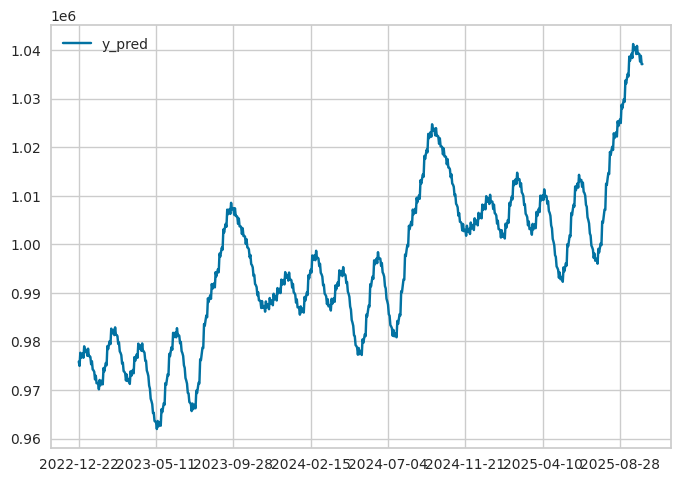

In [94]:
forecast_df_all_prophet.index = forecast_df_all_prophet.index.strftime('%Y-%m-%d')
forecast_df_all_prophet.plot()

In [95]:
forecast_df_all_prophet.columns = ['harga_emas']
forecast_df_all_prophet

harga_emas
2022-12-22  9.758386e+05
2022-12-23  9.749623e+05
2022-12-26  9.776744e+05
2022-12-27  9.766568e+05
2022-12-28  9.772033e+05
...                  ...
2025-10-02  1.039171e+06
2025-10-03  1.037611e+06
2025-10-06  1.038796e+06
2025-10-07  1.037081e+06
2025-10-08  1.037100e+06

[730 rows x 1 columns]

In [96]:
future_exog.index = future_exog.index.strftime('%Y-%m-%d')
future_exog.index

Index(['2022-12-22', '2022-12-23', '2022-12-26', '2022-12-27', '2022-12-28',
       '2022-12-29', '2022-12-30', '2023-01-02', '2023-01-03', '2023-01-04',
       ...
       '2025-09-25', '2025-09-26', '2025-09-29', '2025-09-30', '2025-10-01',
       '2025-10-02', '2025-10-03', '2025-10-06', '2025-10-07', '2025-10-08'],
      dtype='object', length=730)

In [97]:
hasil_forecast_all_prophet = pd.merge(forecast_df_all_prophet, future_exog, left_index=True, right_index=True)
hasil_forecast_all_prophet

harga_emas   kurs_jual   kurs_beli  data_inflasi  suku_bunga_bi
2022-12-22  9.758386e+05  14980.4434  14837.8658        0.0417         3.8466
2022-12-23  9.749623e+05  14976.4806  14833.8928        0.0420         3.8589
2022-12-26  9.776744e+05  14953.3545  14811.1242        0.0419         3.8240
2022-12-27  9.766568e+05  14951.9579  14809.7639        0.0418         3.8084
2022-12-28  9.772033e+05  14947.9782  14805.8328        0.0419         3.7957
...                  ...         ...         ...           ...            ...
2025-10-02  1.039171e+06  15620.1784  15480.9223        0.1021         3.7277
2025-10-03  1.037611e+06  15622.5813  15483.2560        0.1027         3.7484
2025-10-06  1.038796e+06  15616.8674  15477.7612        0.1027         3.7356
2025-10-07  1.037081e+06  15619.7828  15480.6878        0.1025         3.7260
2025-10-08  1.037100e+06  15619.7302  15480.6719        0.1027         3.7186

[730 rows x 5 columns]

<AxesSubplot: >

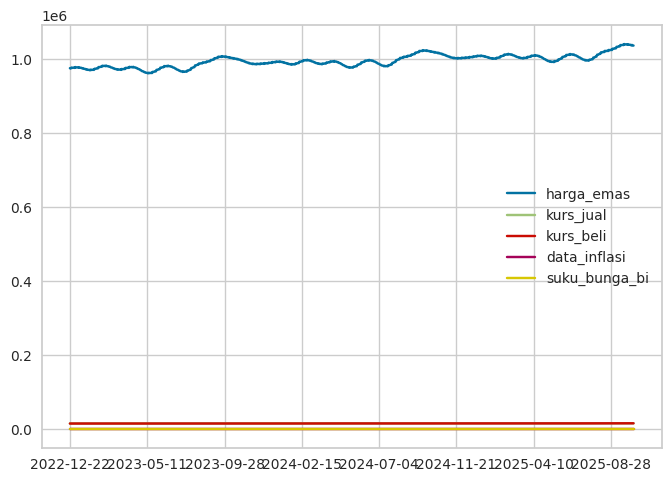

In [98]:
hasil_forecast_all_prophet.plot()

In [99]:
hasil_forecast_all_prophet.index = pd.PeriodIndex(hasil_forecast_all_prophet.index,freq='B')
hasil_forecast_all_prophet

harga_emas   kurs_jual   kurs_beli  data_inflasi  suku_bunga_bi
2022-12-22  9.758386e+05  14980.4434  14837.8658        0.0417         3.8466
2022-12-23  9.749623e+05  14976.4806  14833.8928        0.0420         3.8589
2022-12-26  9.776744e+05  14953.3545  14811.1242        0.0419         3.8240
2022-12-27  9.766568e+05  14951.9579  14809.7639        0.0418         3.8084
2022-12-28  9.772033e+05  14947.9782  14805.8328        0.0419         3.7957
...                  ...         ...         ...           ...            ...
2025-10-02  1.039171e+06  15620.1784  15480.9223        0.1021         3.7277
2025-10-03  1.037611e+06  15622.5813  15483.2560        0.1027         3.7484
2025-10-06  1.038796e+06  15616.8674  15477.7612        0.1027         3.7356
2025-10-07  1.037081e+06  15619.7828  15480.6878        0.1025         3.7260
2025-10-08  1.037100e+06  15619.7302  15480.6719        0.1027         3.7186

[730 rows x 5 columns]

<AxesSubplot: >

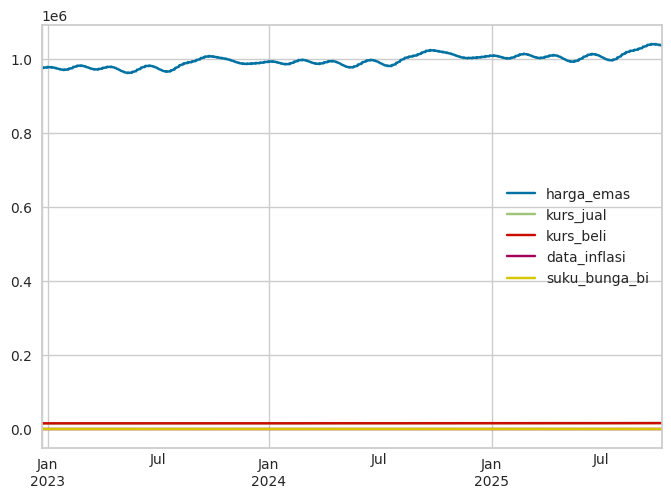

In [100]:
hasil_forecast_all_prophet.plot()

In [101]:
hasil_tabel_emas_pycaret_all_prophet = pd.concat([tabel_emas_mul_pycaret_all_prophet,hasil_forecast_all_prophet])
hasil_tabel_emas_pycaret_all_prophet

harga_emas   kurs_jual   kurs_beli  data_inflasi  \
2010-01-04 00:00:00  4.080000e+05   9377.0000   9283.0000        0.0372   
2010-01-05 00:00:00  4.100000e+05   9355.0000   9261.0000        0.0372   
2010-01-06 00:00:00  4.100000e+05   9355.0000   9261.0000        0.0372   
2010-01-07 00:00:00  4.120000e+05   9274.0000   9182.0000        0.0372   
2010-01-08 00:00:00  4.100000e+05   9286.0000   9194.0000        0.0372   
...                           ...         ...         ...           ...   
2025-10-02           1.039171e+06  15620.1784  15480.9223        0.1021   
2025-10-03           1.037611e+06  15622.5813  15483.2560        0.1027   
2025-10-06           1.038796e+06  15616.8674  15477.7612        0.1027   
2025-10-07           1.037081e+06  15619.7828  15480.6878        0.1025   
2025-10-08           1.037100e+06  15619.7302  15480.6719        0.1027   

                     suku_bunga_bi  
2010-01-04 00:00:00         6.5000  
2010-01-05 00:00:00         6.5000  
2010-01-06 00:00:00         6.5000  
2010-01-07 00:00:00         6.5000  
2010-01-08 00:00:00         6.5000  
...                            ...  
2025-10-02                  3.7277  
2025-10-03                  3.7484  
2025-10-06                  3.7356  
2025-10-07                  3.7260  
2025-10-08                  3.7186  

[4113 rows x 5 columns]

<AxesSubplot: >

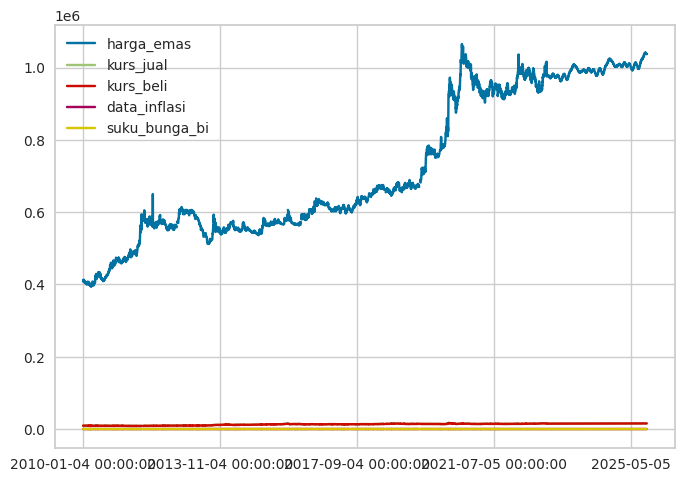

In [102]:
hasil_tabel_emas_pycaret_all_prophet.plot()

In [103]:
hasil_forecast_all_prophet

harga_emas   kurs_jual   kurs_beli  data_inflasi  suku_bunga_bi
2022-12-22  9.758386e+05  14980.4434  14837.8658        0.0417         3.8466
2022-12-23  9.749623e+05  14976.4806  14833.8928        0.0420         3.8589
2022-12-26  9.776744e+05  14953.3545  14811.1242        0.0419         3.8240
2022-12-27  9.766568e+05  14951.9579  14809.7639        0.0418         3.8084
2022-12-28  9.772033e+05  14947.9782  14805.8328        0.0419         3.7957
...                  ...         ...         ...           ...            ...
2025-10-02  1.039171e+06  15620.1784  15480.9223        0.1021         3.7277
2025-10-03  1.037611e+06  15622.5813  15483.2560        0.1027         3.7484
2025-10-06  1.038796e+06  15616.8674  15477.7612        0.1027         3.7356
2025-10-07  1.037081e+06  15619.7828  15480.6878        0.1025         3.7260
2025-10-08  1.037100e+06  15619.7302  15480.6719        0.1027         3.7186

[730 rows x 5 columns]

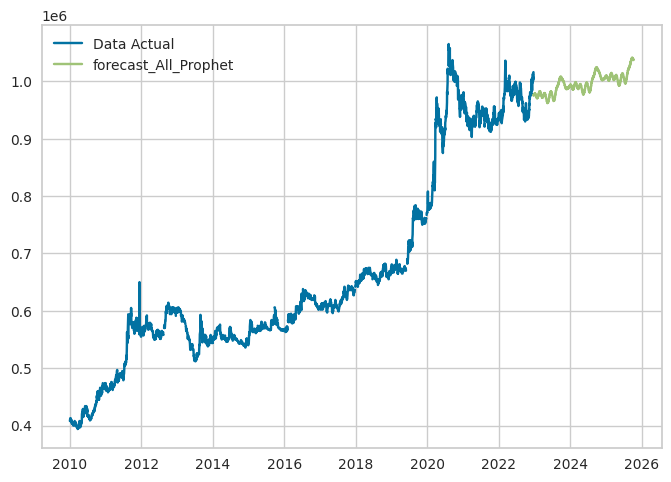

In [104]:
plt.plot(tabel_emas_mul_pycaret_all_prophet.index.to_period().to_timestamp(),tabel_emas_mul_pycaret_all_prophet.harga_emas,label="Data Actual")
plt.plot(hasil_forecast_all_prophet.index.to_timestamp(),hasil_forecast_all_prophet.harga_emas,label="forecast_All_Prophet")
plt.legend()
plt.show()

In [105]:
tabel_emas_mul_pycaret_all_prophet

harga_emas  kurs_jual  kurs_beli  data_inflasi  suku_bunga_bi
tanggal                                                                  
2010-01-04    408000.0    9377.00    9283.00        0.0372            6.5
2010-01-05    410000.0    9355.00    9261.00        0.0372            6.5
2010-01-06    410000.0    9355.00    9261.00        0.0372            6.5
2010-01-07    412000.0    9274.00    9182.00        0.0372            6.5
2010-01-08    410000.0    9286.00    9194.00        0.0372            6.5
...                ...        ...        ...           ...            ...
2022-12-15   1013000.0   15697.09   15540.91        0.0551            5.5
2022-12-16   1000000.0   15708.15   15551.85        0.0551            5.5
2022-12-19   1007000.0   15695.08   15538.92        0.0551            5.5
2022-12-20   1004000.0   15699.10   15542.90        0.0551            5.5
2022-12-21   1016000.0   15686.04   15529.96        0.0551            5.5

[3383 rows x 5 columns]